# Pet-проект: "Разработка модели для предсказания успешности стартапа"

**Описание проекта:**
Предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1980 по 2018 годы, и предсказать, какие из них закроются.

**Цели проекта:**  
1) Разработать модель машинного обучения для предсказания продолжения деятельности стартапа  
2) Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа)

**План проекта:**
1) Загрузка и ознакомление с данными  
2) Предобработка данных  
3) EDA  
4) Корреляционный анализ  
5) Отбор признаков  
6) Обучение моделей  
7) Анализ важности признаков  

**Описание данных:**
* kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
* kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных.
* kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.  

Тренировочный датасет включает в себя следующие столбцы:  
* name - Название стартапа
* category_list - Список категорий, к которым относится стартап
* funding_total_usd - Общая сумма финансирования в USD
* status - Статус стартапа (таргет)
* country_code - Код страны
* state_code - Код штата
* region - Регион
* city - Город
* funding_rounds - Количество раундов финансирования
* founded_at - Дата основания
* first_funding_at - Дата первого раунда финансирования
* last_funding_at - Дата последнего раунда финансирования
* closed_at - Дата закрытия стартапа (если пустое значение, то стартап действует)


## Загрузка и ознакомление с данными  
### Загрузим необходимые библиотеки, функции и файлы с данными

In [1]:
!pip install -q phik
!pip install -q shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import phik
import shap

from scipy import stats as st
from phik.report import plot_correlation_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score

TEST_SIZE = 0.25
RANDOM_STATE = 42

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Функции для исследовательского анализа:
def qq_plots_contrast(data, prep_data, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    stats.probplot(data[col], plot=ax1)
    stats.probplot(prep_data[col], plot=ax2)
    s1 = 'QQ-график '+ col +' (сырой датасет)'
    s2 = 'QQ-график '+ col +' (обработанный датасет)'
    
    ax1.set_title(s1)
    ax2.set_title(s2)
    plt.tight_layout()
    plt.show();

def boxplot_hist(data, prep_data, col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    color_palette1 = sns.color_palette("Set1")[0]
    sns.histplot(data[col], bins=20, color=color_palette1, ax=axs[0, 0])
    sns.boxplot(data[col], color=color_palette1, ax=axs[1, 0])

    color_palette2 = sns.color_palette("Set1")[1]
    sns.histplot(prep_data[col], bins=20, color=color_palette2, ax=axs[0, 1])
    sns.boxplot(prep_data[col], color=color_palette2, ax=axs[1, 1])

    axs[0, 0].set_title('Гистограмма с сырым признаком')
    axs[0, 0].axvline(data[col].mean(), color='r', linestyle='--', label='Среднее значение')
    axs[0, 0].axvline(data[col].median(), color='g', linestyle='-.', label='Медиана')
    axs[1, 0].set_title('Ящик с усами для сырого признака')
    axs[1, 0].set_xlabel(col)
    axs[1, 0].set_ylabel('Значение')
    
    axs[0, 1].set_title('Гистограмма для обработанного признака')
    axs[0, 1].axvline(prep_data[col].mean(), color='r', linestyle='--', label='Среднее значение')
    axs[0, 1].axvline(prep_data[col].median(), color='g', linestyle='-.', label='Медиана')
    axs[1, 1].set_title('Ящик с усами для обработанного признака')
    axs[1, 1].set_xlabel(col)
    axs[1, 1].set_ylabel('Значение')

    plt.tight_layout()
    plt.show();
    
def eda_category(data1, data2=None, column=None, contrast=0):
    if contrast == 0:
        object_cols = list(data1.select_dtypes(include=['object']).columns)
        for cat in object_cols:
            if cat != 'name' and cat != 'category_list':
                if len(data1[cat].unique()) <= 3:
                    cor_obj = data1[cat].value_counts()
                    plt.figure(figsize=(4, 4))
                    plt.pie(cor_obj, \
                        labels=cor_obj.index, \
                        autopct='%1.1f%%',\
                        startangle=140,\
                        colors=['#6C93DE', '#DE6C6C'])
                    plt.axis('equal')
                    s = 'Встречаемость категорий столбца ' + cat
                    plt.title(s)
                    plt.show()
                else:
                    popular_categories = data1[cat].value_counts().nlargest(5)
                    rare_categories = data1[cat].value_counts().nsmallest(5)
                    final_categories = pd.concat([popular_categories, rare_categories])
                    
                    plt.figure(figsize=(8, 6))
                    sns.barplot(x=final_categories.values, y=final_categories.index, palette='Blues_d')
                    s = 'Частота встречаемости категорий ' + cat
                    plt.title(s)
                    plt.xlabel('Частота')
                    plt.ylabel('Категория')
                    plt.show();
    if contrast == 1:
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        popular_categories1 = data1[column].value_counts().nlargest(5)
        popular_categories2 = data2[column].value_counts().nlargest(5)
        sns.barplot(x=popular_categories1.values, y=popular_categories1.index, \
                    palette='Blues_d', ax=axs[0])
        sns.barplot(x=popular_categories2.values, y=popular_categories2.index, \
                    palette='Reds_d', ax=axs[1])

        axs[0].set_title(f'Популярные {column} в действующих стартапах')
        axs[1].set_title(f'Популярные {column} в закрытых стартапах')
        axs[0].set_ylabel(None)
        axs[1].set_ylabel(None)
        plt.show();
        
        
def histogram(data, col, xmin, xmax):
    sns.histplot(data[col], bins=150, color='#6C93DE', kde=True)
    s = 'Гистограмма столбца '+col
    plt.title(s)
    plt.xlabel('Значения')
    plt.ylabel('Встречаемость')
    plt.xlim(pd.to_datetime(xmin), pd.to_datetime(xmax))
    
    # Установка чаще выводимых дат на оси x (только год)
    years = pd.date_range(start=pd.to_datetime(xmin), end=pd.to_datetime(xmax), freq='2YS')
    years_str = [str(year.year) for year in years]
    plt.xticks(ticks=years, labels=years_str, rotation=45)  
    plt.show();

def stats_contrast(data_operating, data_closed, feature):
    sns.histplot(data_operating[feature], color='blue', kde=True, label='Operating')
    sns.histplot(data_closed[feature], color='red', kde=True, label='Closed')
    mean_dataset1 = data_operating[feature].mean()
    mean_dataset2 = data_closed[feature].mean()
    plt.axvline(mean_dataset1, color='blue', linestyle='dashed', \
                linewidth=2, label=f'Среднее действующих: {mean_dataset1:.2f}')
    plt.axvline(mean_dataset2, color='red', linestyle='dashed', \
                linewidth=2, label=f'Среднее закрытых: {mean_dataset2:.2f}')
    plt.xlabel(feature)
    plt.legend()
    plt.show();
    
def boxplot_multiple_columns(data):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, orient="v", palette="Set2")
    plt.xticks(rotation=45)
    plt.title('Ящики с усами для временных столбцов')
    plt.ylabel('Значения')
    plt.xlabel('Признаки')
    #plt.xlim(pd.to_datetime(xmin), pd.to_datetime(xmax))
    plt.show();

/kaggle/input/startups-competition/kaggle_startups_sample_submit_01.csv
/kaggle/input/startups-competition/kaggle_startups_train_01.csv
/kaggle/input/startups-competition/kaggle_startups_test_01.csv


In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
data_train = pd.read_csv('/kaggle/input/startups-competition/kaggle_startups_train_01.csv')
data_test = pd.read_csv('/kaggle/input/startups-competition/kaggle_startups_test_01.csv')
sample_submit = pd.read_csv('/kaggle/input/startups-competition/kaggle_startups_sample_submit_01.csv')

**Итого:** загружены необходимые библиотеки и функции, загружены датасеты.

### Изучим первые строки тренировочного датасета и общую информацию

In [5]:
display(data_train.head())
print()
data_train.info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


**Итого:** тренировочный датасет имеет 52879 объектов и 13 признаков (включая таргет). В данных содержатся пропуски. Также дата хранится как object, а не как datetime. Это будет исправлено в предобработке данных.

### Изучим первые строки тестового датасета и общую информацию

In [6]:
display(data_test.head())
print()
data_test.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,34700000.00,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,4530000.00,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


**Итого**: тестовый датасет имеет 13211 объект и 12 признаков. В данных содержатся пропуски. Дата хранится в виде строки.

**Вывод:** изучены первые строки и общая информация о датасетах. В данных были найдены пропуски, поэтому датасеты требуют предобработки.

## Предобработка данных  
### Сделаем контроль размеров тренировочного датасета

In [7]:
data_train_temp = data_train.shape
data_train_temp

(52879, 13)

### Приведём столбцы с датой в нужный формат

In [8]:
# Отформатируем дату в тренировочном датасете
data_train['founded_at'] = pd.to_datetime(data_train['founded_at'], format='%Y-%m-%d')

data_train['first_funding_at'] = pd.to_datetime(data_train['first_funding_at'], format='%Y-%m-%d')

data_train['last_funding_at'] = pd.to_datetime(data_train['last_funding_at'], format='%Y-%m-%d')

data_train['closed_at'] = pd.to_datetime(data_train['closed_at'], format='%Y-%m-%d')


# Отформатируем дату в тестовоом датасете
data_test['founded_at'] = pd.to_datetime(data_test['founded_at'],format='%Y-%m-%d')

data_test['first_funding_at'] = pd.to_datetime(data_test['first_funding_at'],format='%Y-%m-%d')

data_test['last_funding_at'] = pd.to_datetime(data_test['last_funding_at'],format='%Y-%m-%d')

data_test['closed_at'] = pd.to_datetime(data_test['closed_at'],format='%Y-%m-%d')

In [9]:
display(data_train.info())
display(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52878 non-null  object        
 1   category_list      50374 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             52879 non-null  object        
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     52879 non-null  int64         
 9   founded_at         52879 non-null  datetime64[ns]
 10  first_funding_at   52858 non-null  datetime64[ns]
 11  last_funding_at    52879 non-null  datetime64[ns]
 12  closed_at          4962 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13211 non-null  object        
 1   category_list      12610 non-null  object        
 2   funding_total_usd  10616 non-null  float64       
 3   country_code       11827 non-null  object        
 4   state_code         11512 non-null  object        
 5   region             11618 non-null  object        
 6   city               11620 non-null  object        
 7   funding_rounds     13211 non-null  int64         
 8   founded_at         13211 non-null  datetime64[ns]
 9   first_funding_at   13211 non-null  datetime64[ns]
 10  last_funding_at    13211 non-null  datetime64[ns]
 11  closed_at          1234 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(6)
memory usage: 1.2+ MB


None

**Итого:** даты в нужном формате

### Изучим тренировочный датасет на дубликаты

#### Изучим на явные дубликаты

In [10]:
data_train.duplicated().sum()

0

**Итого**: явных дубликатов нет

#### Изучим тренировочный датасет на неявные дубликаты  
Приведём все категориальные значения в нижний регистр и посмотрим, появились ли дубликаты. Заодно привидём в нижний регистр столбцы тестового датасета, оставишь как есть ли имя компании

In [11]:
cat_cols = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']
for cat in cat_cols:
    if cat != 'name':
        data_train[cat] = data_train[cat].str.lower()
        data_test[cat] = data_test[cat].str.lower()
    else:
        data_train[cat] = data_train[cat].str.lower()

In [12]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,lunchgate,online reservations|restaurants,828626.00,operating,che,25,zurich,zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
1,earlens,manufacturing|medical|medical devices,42935019.00,operating,usa,ca,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,reviva pharmaceuticals,biotechnology,35456381.00,operating,usa,ca,sf bay area,san jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,sancilio and company,health care,22250000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,wiretough cylinders,manufacturing,NaN,operating,usa,va,va - other,bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT


In [13]:
data_train.duplicated().sum()

0

Теперь попробуем найти дубликаты, погруппировав названия компаний и их описание, стану и т.д

In [14]:
obj_cols = list(data_train.select_dtypes(include=['object']).columns)
for col in range(1, len(obj_cols)):
    summ = data_train[['name', obj_cols[col]]].duplicated().sum()
    print(f'Количество дубликатов по столбцам name и {obj_cols[col]} равно {summ}')

Количество дубликатов по столбцам name и category_list равно 0
Количество дубликатов по столбцам name и status равно 37
Количество дубликатов по столбцам name и country_code равно 12
Количество дубликатов по столбцам name и state_code равно 7
Количество дубликатов по столбцам name и region равно 5
Количество дубликатов по столбцам name и city равно 5


Количество дубликатов по столбцам name и status равно 37. Возможно это дочернии компании, а если это так, что у них должны быть разные сферы деятельности. Попробуем погруппировать по три признака

In [15]:
for col in range(1, len(obj_cols)-1):
    summ = data_train[['name', obj_cols[col], obj_cols[col+1]]].duplicated().sum()
    print(f'Количество дубликатов по столбцам name, {obj_cols[col]} и {obj_cols[col+1]} равно {summ}')

Количество дубликатов по столбцам name, category_list и status равно 0
Количество дубликатов по столбцам name, status и country_code равно 12
Количество дубликатов по столбцам name, country_code и state_code равно 6
Количество дубликатов по столбцам name, state_code и region равно 5
Количество дубликатов по столбцам name, region и city равно 5


Количество дубликатов по столбцам name, category_list и status равно 0 - предположение о дочерних компаниях подтвердилось. Дубликаты, связанные с именами компаний и их географическим положением не смущают, поскольку дочернии компании могут быть в одной стране/штате/городе. Проверить это можно, сгруппировав компании по имени и сфере деятельности. Если окажется, что у компании одно и то же название, одна и та же сфера деятельности, так ещё и географическое положение совпадает, то это точно дубликат.

In [16]:
geo = ['country_code', 'state_code', 'region', 'city']
for col in geo:
    summ = data_train[['name', 'category_list', col]].duplicated().sum()
    print(f'Количество дубликатов по {col} равно {summ}')

Количество дубликатов по country_code равно 0
Количество дубликатов по state_code равно 0
Количество дубликатов по region равно 0
Количество дубликатов по city равно 0


**Итого**: неявные дубликаты не обнаружены

### Поработаем с пропусками  

In [17]:
data_train.isna().sum()

name                     1
category_list         2505
funding_total_usd    10126
status                   0
country_code          5528
state_code            6797
region                6390
city                  6390
funding_rounds           0
founded_at               0
first_funding_at        21
last_funding_at          0
closed_at            47917
dtype: int64

#### Заполним пропуски в столбце closed_at
Эти пропуски возникли не случайно, пропуски обозначают, что компания ещё действует. Заполним этим пропуски датой выгрузки данных, чтобы впоследствии получить признак "время существования компании"

In [18]:
data_train['closed_at'] = data_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))
data_test['closed_at'] = data_test['closed_at'].fillna(pd.to_datetime('2018-01-01'))

In [19]:
data_train['closed_at'].head(10)

0   2018-01-01
1   2018-01-01
2   2018-01-01
3   2018-01-01
4   2018-01-01
5   2018-01-01
6   2018-01-01
7   2018-01-01
8   2018-01-01
9   2018-01-01
Name: closed_at, dtype: datetime64[ns]

In [20]:
data_train.isna().sum()

name                     1
category_list         2505
funding_total_usd    10126
status                   0
country_code          5528
state_code            6797
region                6390
city                  6390
funding_rounds           0
founded_at               0
first_funding_at        21
last_funding_at          0
closed_at                0
dtype: int64

#### Удалим некоторые объекты  
Удалим объекты, в которых неизвестны country_code, state_code и region одновременно, поскольку такие объекты мало информативны.

In [21]:
data_train = data_train.dropna(subset=['country_code', 'state_code', 'region'])

In [22]:
data_train.isna().sum()

name                    1
category_list        1238
funding_total_usd    7978
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at       19
last_funding_at         0
closed_at               0
dtype: int64

**Итого:** объекты с пропущенной информацией в столбцах country_code, state_code и region удалены. Такие значения удалили с собой ещё больше пропусков в столбцах funding_total_usd, city и closed_at. Удалено 6390 объектов без географического положения.

#### Заполним пропуски в числовых столбцах
В датасете обнаружилось большое количество пропусков. Совершенно не хочется заполнять все пропуски средним/медианой всего столбца. Вместо этого рассмотрим другой способ:  
Сгруппируем данные по категориальным столбцам (country_code, state_code, region) и найдем медиану искомого признака конкретно для такого типа пропусков (с таким же country_code, state_code, region). Группировать по city не будем, чтобы информация носила более общий характер. Заполним таким способом пропуски в funding_total_usd:

*p.s: поскольку мы ещё не проводили EDA и не удалили выбросы, то лучше всего заполнять пропуски именно медианой, поскольку она менее чувствительна к выбросам.*

In [23]:
data_train[['country_code','state_code','region', 'funding_total_usd']].sample(10, random_state=1)

,country_code,state_code,region,funding_total_usd
50818,usa,ny,new york city,NaN
46193,sau,10,riyadh,300000.00
48702,usa,fl,ft. lauderdale,NaN
31179,usa,tx,austin,1000000.00
3481,usa,ca,sf bay area,NaN
31675,usa,ny,new york city,275000.00
18810,gbr,m3,bradford,NaN
33339,usa,ca,napa valley,266950270.00
31077,chl,12,santiago,234355.00
5935,usa,ca,sf bay area,15486363.00


In [24]:
funding_total_classes = data_train.groupby(['country_code','state_code','region']) \
    ['funding_total_usd'].transform("median")
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(funding_total_classes)

#Проделаем то же самое с тестовыми данными
funding_total_classes_test = data_test.groupby(['country_code','state_code','region']) \
    ['funding_total_usd'].transform("median")
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(funding_total_classes_test)

#Где не получится - заполним медианой
mediana_train = data_train['funding_total_usd'].median()
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(value=mediana_train)

mediana_test = data_test['funding_total_usd'].median()
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(value=mediana_test)

In [25]:
data_train[['country_code','state_code','region', 'funding_total_usd']].sample(10, random_state=1)

,country_code,state_code,region,funding_total_usd
50818,usa,ny,new york city,2000000.00
46193,sau,10,riyadh,300000.00
48702,usa,fl,ft. lauderdale,1070000.00
31179,usa,tx,austin,1000000.00
3481,usa,ca,sf bay area,5200000.00
31675,usa,ny,new york city,275000.00
18810,gbr,m3,bradford,10000000.00
33339,usa,ca,napa valley,266950270.00
31077,chl,12,santiago,234355.00
5935,usa,ca,sf bay area,15486363.00


*p.s: в объектах 50818, 48702, 3481, 18810 были пропуски, а теперь нет*

In [26]:
data_train.isna().sum()

name                    1
category_list        1238
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at       19
last_funding_at         0
closed_at               0
dtype: int64

**Итого:** пропуски в funding_total_usd заполнены.

#### Посмотрим, сколько данных было удалено всего:

In [27]:
deleted = np.round(((data_train_temp[0] - data_train.shape[0])/data_train_temp[0])*100)
print(f'Удалено {deleted}% данных')

Удалено 13.0% данных


**Вывод:** данные предобработаны - выполнен анализ на явные дубликаты, удалены объекты с большим количеством пропусков в ключевых категориях, заполнены пропуски в числовых столбцах. Удалено 13.0% данных - довольно большое число, но в оставшихся данных можно быть полностью уверенным.

## EDA
### Изучим данные

#### Изучим числовые столбцы

In [28]:
num_columns = list(data_train.select_dtypes(include=['int', 'float']).columns)
data_train[num_columns].describe()

,funding_total_usd,funding_rounds
count,45846.00,45846.00
mean,16613908.66,1.81
std,188219293.24,1.43
min,1.00,1.00
25%,520023.50,1.00
50%,2150000.00,1.00
75%,8157093.25,2.00
max,30079503000.00,19.00


**Итого:**  
1) **funding_total_usd**: минимальное значение 1 доллар, максимальное - 30079503000 долларов. Первый, второй и третий квартиль равны 515626, 2150000 и 8200000 соответственно. Сложно говорить о выбросах, поскольку стандратное отклонение признака равно 188 миллионов.  
2) **funding_rounds**: минимальное значение 1, максимальное 19. Первый и второй квартили равны 1, а третий равен 2. При стандартном отклонении, равным 1.43, кажется, что будут только выбросы в большую сторону.  

Исследуем числовой столбец funding_total_usd
Посмотрим, сколько процентов объектов со значением funding_total_usd содержаться за пределами межквартильного размаха, умноженного на 1.5

In [29]:
q1 = data_train['funding_total_usd'].quantile(0.25)
q3 = data_train['funding_total_usd'].quantile(0.75)
iqr = (q3-q1)*1.5

print(
    (data_train[(data_train['funding_total_usd']<q1-iqr)|((data_train['funding_total_usd']>q3+iqr))] \
     .shape[0]/data_train.shape[0])*100
)

14.476726431967894


**Итого:** 14.45% находится за пределами межквартильно размаха, умноженного на 1.5. Довольно большое число, поэтому повторим те же вычисления, но умножим межквартильный размах на 3

In [30]:
q1 = data_train['funding_total_usd'].quantile(0.25)
q3 = data_train['funding_total_usd'].quantile(0.75)
iqr = (q3-q1)*3

print(
    (data_train[(data_train['funding_total_usd']<q1-iqr)|((data_train['funding_total_usd']>q3+iqr))] \
     .shape[0]/data_train.shape[0])*100
)

9.7500327182306


**Итого:** 9.71% - всё ещё большое число, а удалять много данных не всегда хорошая практика. 

Поступим так: создадим отдельный датафрейм prep_data_train, куда будем складывать данные без выбросов.

In [31]:
prep_data_train = data_train[(data_train['funding_total_usd']>=q1-iqr) \
                             &((data_train['funding_total_usd']<=q3+iqr))]
print(prep_data_train.shape[0])

41376


Построим ящики с усами и гистограммы для необработанного и обработанного признаков

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


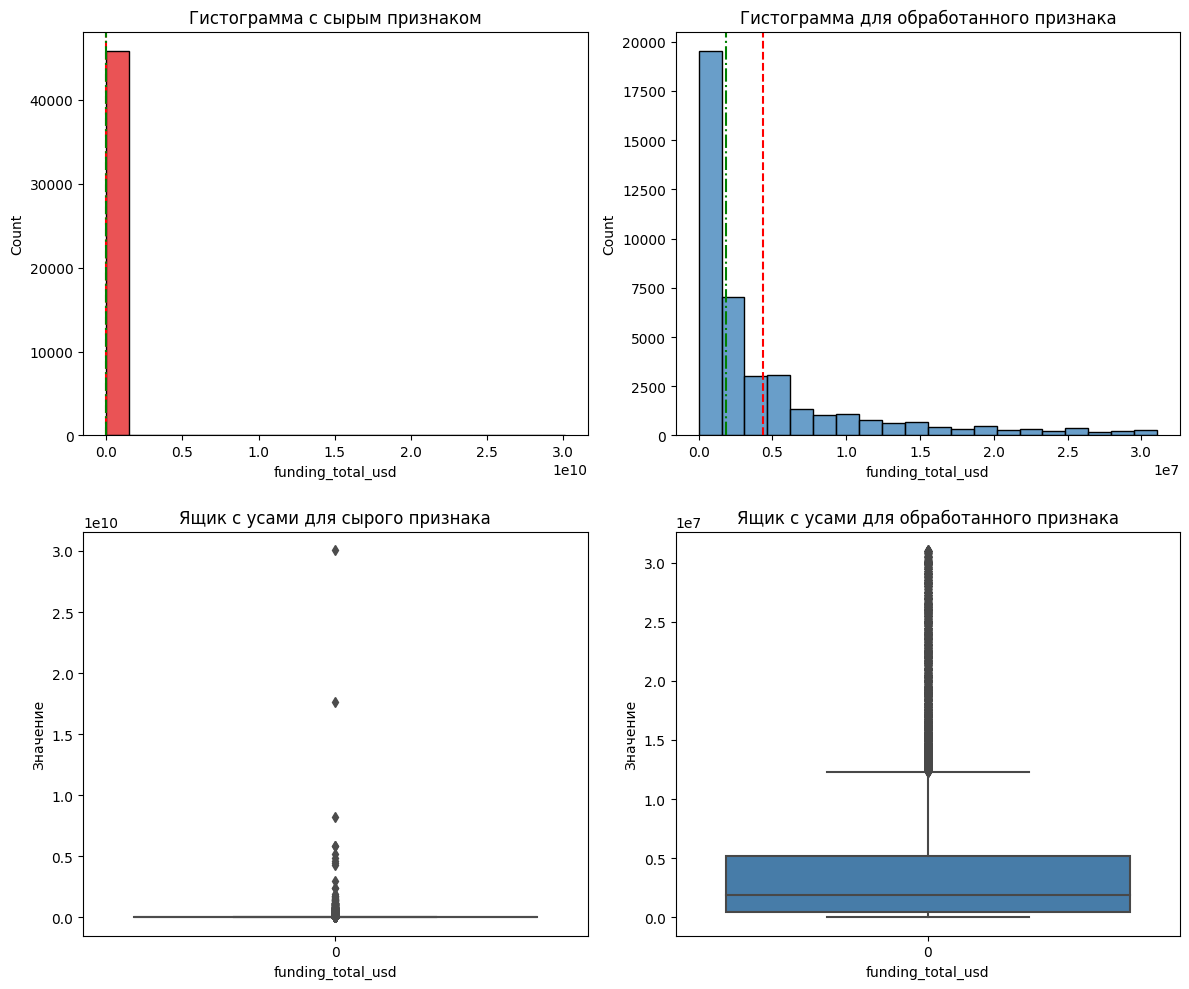

In [32]:
boxplot_hist(data_train, prep_data_train, 'funding_total_usd')

**Итого**: хоть и у обработанного признака ещё остались выбросы (поскольку метод hist считает выбросами всё что дальше 1.5 межвкартильного размаха), ящик с усами и гистограмма выглядят значительно лучше, по сравнению с необработанным признаком, уменьшился масштаб. Видно, что среднее и медиана данных изменились.

Помимо возможных выбросов нам важно знать вид распределения, эта информация нам пригодится для корреляционного анализа. Построим QQ-графики для датасета без выбросов и с выбросами.

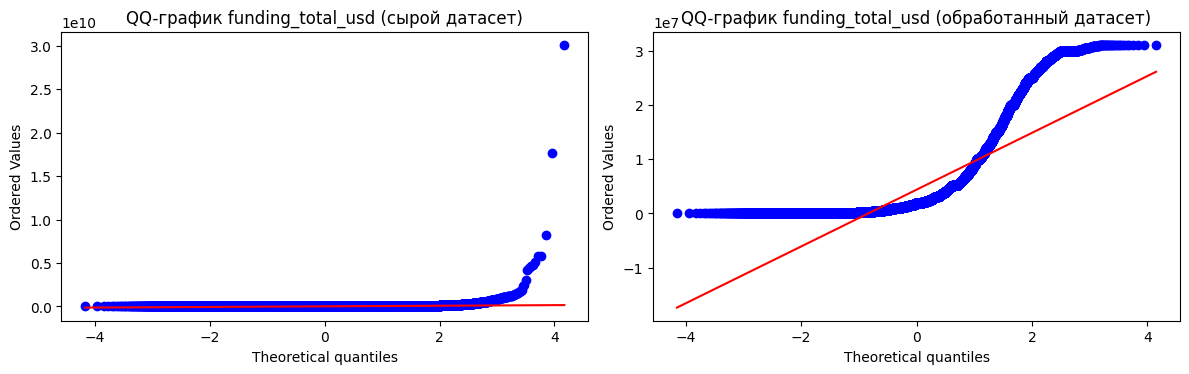

In [33]:
qq_plots_contrast(data_train, prep_data_train, 'funding_total_usd')

**Итого**: обработанный признак стал ближе к нормальному распределению, хотя до него ещё далеко. Изначально seaborn даже не смог построить теоретическое нормальное распределение, что является сигналом о том, что данные весьма плохи. В обработанном признаке уже видно теоретическое нормальное распределение и наблюдается более сложная структура распределения

Исследуем числовой столбец funding_rounds.
Посмотрим, сколько процентов объектов со значением funding_total_usd содержаться за пределами межквартильного размаха, умноженного на 1.5

In [34]:
q1 = data_train['funding_rounds'].quantile(0.25)
q3 = data_train['funding_rounds'].quantile(0.75)
iqr = (q3-q1)*1.5

print(
    (data_train[(data_train['funding_rounds']<q1-iqr)|((data_train['funding_rounds']>q3+iqr))] \
     .shape[0]/data_train.shape[0])*100
)

10.08812110107752


10% данных находится за пределами межквартильно размаха, умноженного на 1.5.
Попробуем умножить межквартильный размах на 3

In [35]:
q1 = data_train['funding_rounds'].quantile(0.25)
q3 = data_train['funding_rounds'].quantile(0.75)
iqr = (q3-q1)*3

print(
    (data_train[(data_train['funding_rounds']<q1-iqr)|((data_train['funding_rounds']>q3+iqr))] \
     .shape[0]/data_train.shape[0])*100
)

3.0013523535313875


3%, уже гораздо лучше. Выбросим эти 3% наблюдений из выборки.

In [36]:
pred_data_train = data_train[(data_train['funding_rounds']>=q1-iqr) \
                             &((data_train['funding_rounds']<=q3+iqr))]
print(pred_data_train.shape[0])

44470


Посмотрим на ящик с усами и гистограмму этого признака в обычно и обработанном датасете.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


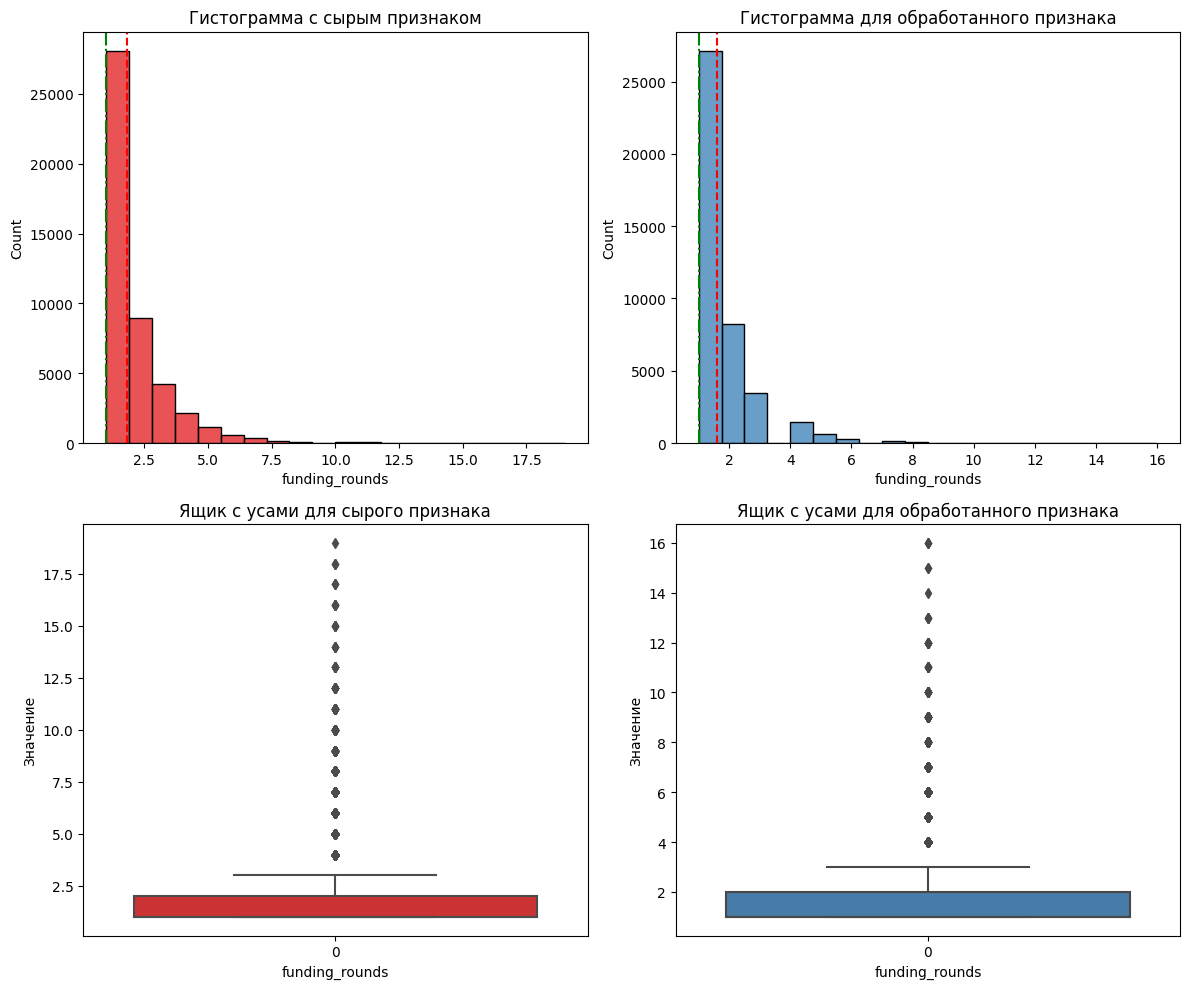

In [37]:
boxplot_hist(data_train, prep_data_train, 'funding_rounds')

**Итого:** в целом, больших отличий нет. Видно, что удалились некоторые пиковые значения, поскольку диапазон оси значений в ящике с усами уменьшился. Возможно, это избыточная обработка.

Изучим QQ-графики сырых и предобработанных данных признака funding_rounds

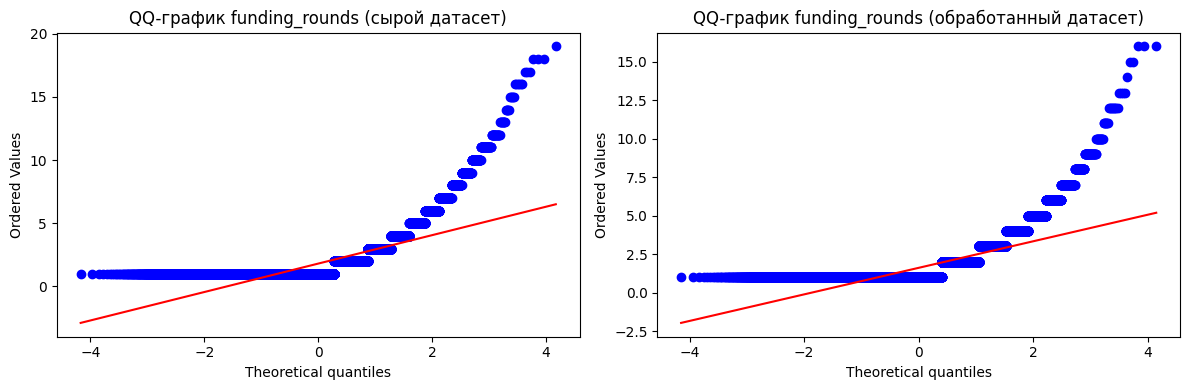

In [38]:
qq_plots_contrast(data_train, prep_data_train, 'funding_rounds')

**Итого**: больших отличий между сырым о обработанным признаком нет

**Вывод**: обработаны числовые столбцы тренировочного датасета, найдены выбросы. Изучены распределения числовых признаков, нормальных среди них обнаружено не было, это важно учесть при корреляционном анализе. В данных найдены выбросы, было решено создать отдельный датафрейм с обработанными данными - в случае плохой обобщающей способности модели вернёмся к изначальному датфрейму.

#### Изучим категориальные столбцы

Узнаем количество уникальных значений каждого категориального столбца

In [39]:
object_cols = list(data_train.select_dtypes(include=['object']).columns)
for col in object_cols:
    print(f'В столбце {col} {len(data_train[col].unique())} уникальных значений')

В столбце name 45819 уникальных значений
В столбце category_list 19480 уникальных значений
В столбце status 2 уникальных значений
В столбце country_code 113 уникальных значений
В столбце state_code 295 уникальных значений
В столбце region 1010 уникальных значений
В столбце city 4480 уникальных значений


**Итого**: больше всего уникальных значений в столбце name, поскольку имя компании обычно уникально. Меньше всего уникальных значений в столбце status - наш таргет, поскольку он принимает только значения closed и operating.

Изучим распределение классов на данные. Для того, чтобы продемонстрировать дисбаланс классов, возьмём топ-5 самых популярных категорий и топ-5 самых НЕпопулярных категорий и отметим их велечины на одном графике.

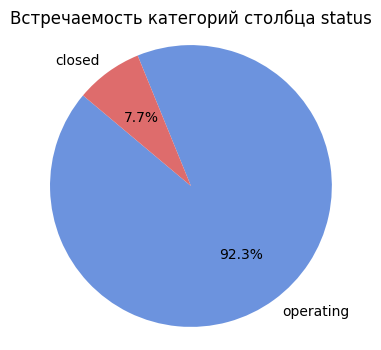

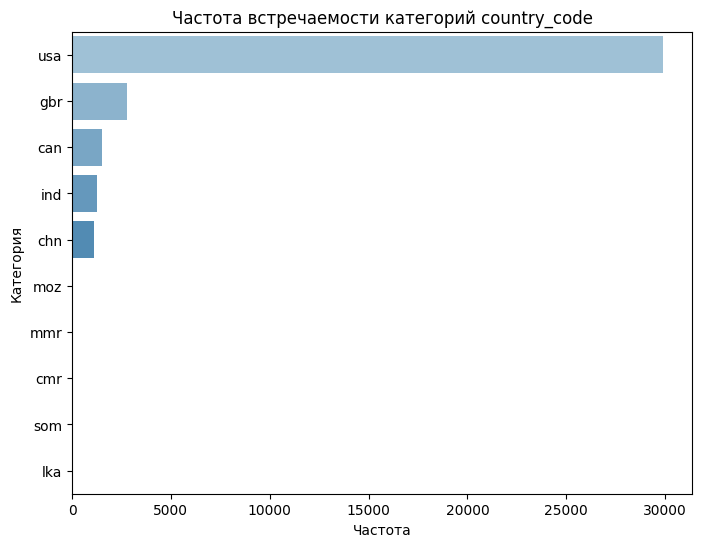

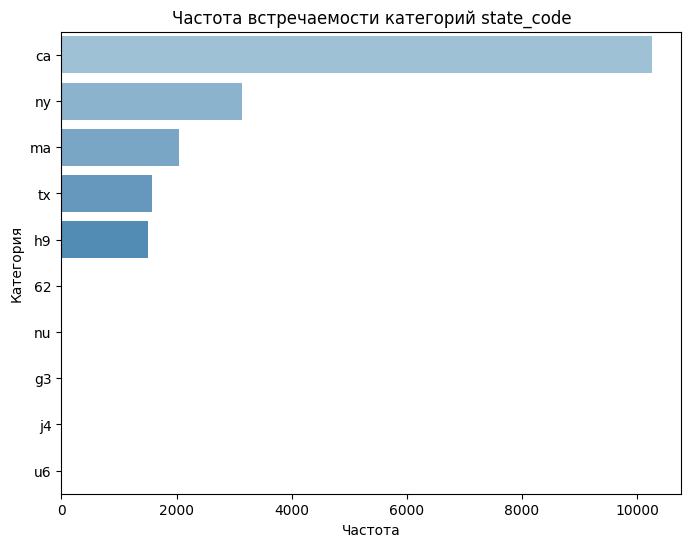

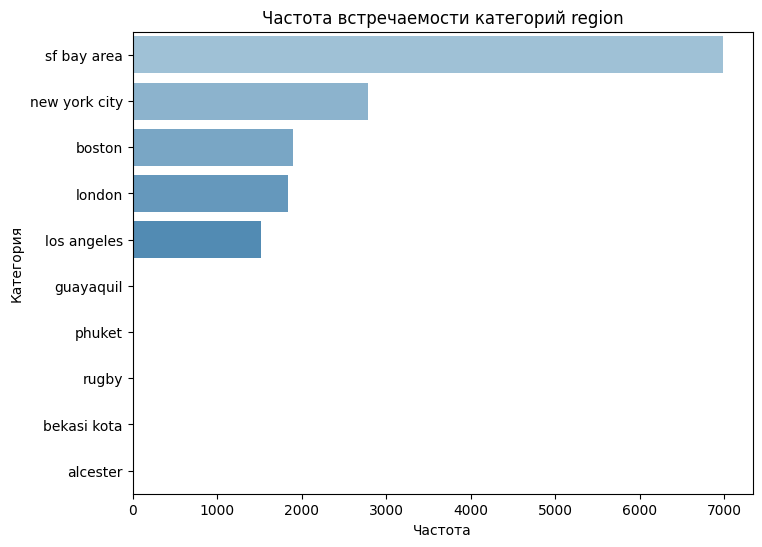

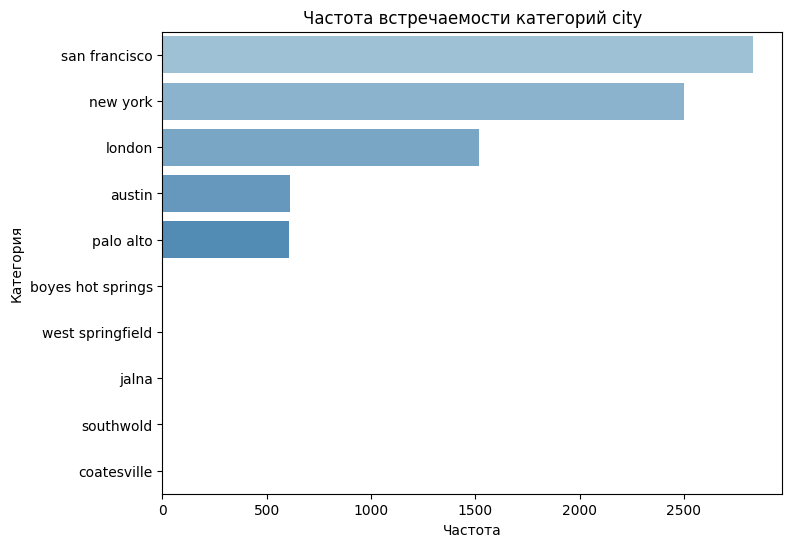

In [40]:
eda_category(data_train)

**Итого**: в данных обнаружен сильный дисбаланс классов, одни категории имеют сотни и тысячи наблюдений, а другие едва набирают десяток. С такими признаками будет очень тяжело работать, в частности кодировать с помощью One Hot Encoding. Нужно решить, что делать с такими признаками. Хорошим решением кажется выбрать популярые категории и выделить их в отдельные признаки, а непопулярные добавить в категорию "другое".

**Вывод**: проведена работа с категориальныит признаками, выявлен дисбаланс классов. Определена дальнейшая работа с такими признаками.

#### Изучим временные столбцы столбцы

In [41]:
date_cols = list(data_train.select_dtypes(include=['datetime64[ns]']).columns)
data_train[date_cols].describe()

,founded_at,first_funding_at,last_funding_at,closed_at
count,45846,45827,45846,45846
mean,2008-02-13 02:28:37.785629952,2011-06-25 09:47:09.676828160,2012-07-09 07:06:04.193168384,2017-07-09 12:19:34.087161600
min,1749-01-01 00:00:00,1960-01-01 00:00:00,1977-05-15 00:00:00,1983-07-04 00:00:00
25%,2006-02-01 00:00:00,2009-09-23 00:00:00,2011-02-05 00:00:00,2018-01-01 00:00:00
50%,2010-05-01 00:00:00,2012-06-01 00:00:00,2013-08-21 00:00:00,2018-01-01 00:00:00
75%,2012-10-01 00:00:00,2014-03-01 00:00:00,2014-11-10 00:00:00,2018-01-01 00:00:00
max,2016-01-01 00:00:00,2015-12-05 00:00:00,2105-05-01 00:00:00,2106-07-20 00:00:00


В описании к датасету сказано, что временной период данных с '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01', а это значит, что в столбцах last_funding_at и closed_at содержатся аномалии в виде слишком далёкой даты. Избавимся от этих значений в основном датасете и предобработанном датасетах

In [42]:
data_train[data_train['last_funding_at']>'2018-01-01']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
7119,rasyonel r&d,embedded hardware and software|internet of thi...,220000.00,closed,tur,35,izmir,izmir,3,2013-03-20,2013-04-05,2105-05-01,2106-07-20


In [43]:
data_train[data_train['closed_at']>'2018-01-01']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
7119,rasyonel r&d,embedded hardware and software|internet of thi...,220000.00,closed,tur,35,izmir,izmir,3,2013-03-20,2013-04-05,2105-05-01,2106-07-20


Как видно, оба аномальных значения хранит один объект. Избавимся от него

In [44]:
data_train = data_train.drop(7119)
prep_data_train = prep_data_train.drop(7119)

In [45]:
data_train[data_train['closed_at']>'2018-01-01']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


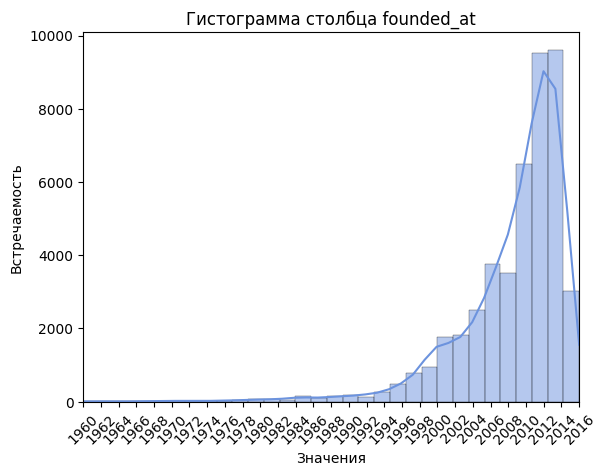

In [46]:
histogram(data_train, 'founded_at', '1960-01-01', max(data_train['founded_at']))

**Итого:** в среднем, с каждым годом основывается всё больше и больше компаний. Положительная динамика создания компаний началась в 1992-1993 годах (линия, сглаживающая распределение начала отрываться от нуля) - в это время открылось примерно 200 компаний, а уже к 2000 году открылось 2000 компаний. Пик открытий пришёлся на 2013-2014 год - открылось чуть меньше 10000 компаний, после этого наблюдается резкий спад.  
Заметим, что временные данные не соответсвуют описанию данных, поскольку в описании указан временной период '1970-01-01' по '2018-01-01'!

В предобработанном датасете будем хранить только данные, которые соответствующие периоду '1970-01-01' по '2018-01-01':

In [47]:
min_date = pd.to_datetime('1970-01-01')
max_date = pd.to_datetime('2018-01-01')
prep_data_train = prep_data_train[(prep_data_train['founded_at']>=min_date)\
                                  & (prep_data_train['founded_at']<=max_date)]

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


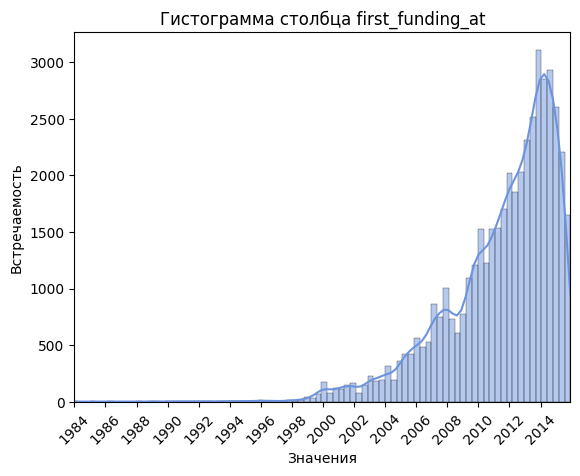

In [48]:
histogram(data_train, 'first_funding_at', '1984-01-01', max(data_train['first_funding_at']))

In [49]:
min_date = pd.to_datetime('1970-01-01')
max_date = pd.to_datetime('2018-01-01')
prep_data_train = prep_data_train[(prep_data_train['first_funding_at']>=min_date) \
                      & (prep_data_train['first_funding_at']<=max_date)]

**Итого:** Положительная динамика старта первых раундов финансирования началась в 1998 году, больше всего первых раундов финансирования было начато в 2013-2014 году, после этого наблюдается резкий спад

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


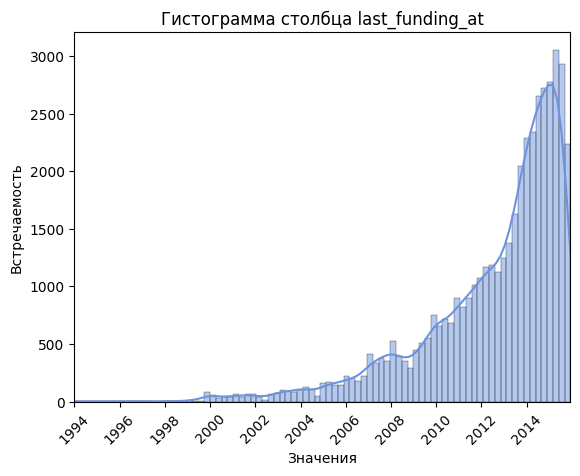

In [50]:
histogram(data_train, 'last_funding_at', '1994-01-01', max(data_train['last_funding_at']))

In [51]:
min_date = pd.to_datetime('1970-01-01')
max_date = pd.to_datetime('2018-01-01')
prep_data_train = prep_data_train[(prep_data_train['last_funding_at']>=min_date) \
                      & (prep_data_train['last_funding_at']<=max_date)]

**Итого:** Положительная динамика старта последних раундов финансирования началась в 2000 году и эта динамика медленно росла до 2006, активный рост наблюдается с 2009 года, линия, сглаживающая распределение, стала круче. Больше всего первых раундов финансирования было начато в 2013-2014 году, после этого наблюдается резкий спад

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


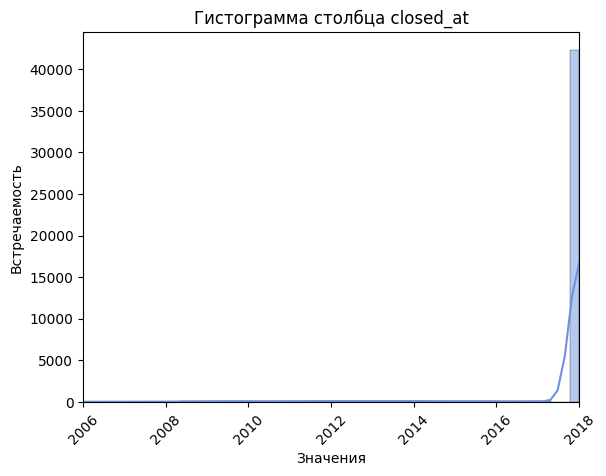

In [52]:
histogram(data_train, 'closed_at', '2006-01-01', max(data_train['closed_at']))

**Итого:** такое распределение в виде одного столбца наблюдается из-за дисбаланса классов, поскольку действующий компаний 92.3%, а даты "закрытия" были заполнены датой выгрузки данных.

In [53]:
min_date = pd.to_datetime('1970-01-01')
max_date = pd.to_datetime('2018-01-01')
prep_data_train = prep_data_train[(prep_data_train['closed_at']>=min_date) \
                                  & (prep_data_train['closed_at']<=max_date)]

In [54]:
prep_data_train.shape

(41138, 13)

**Итого**:  Проведён анализ временных данных, определены даты, на которые приходилось больше всего приходилось открытий компаний, проведений инвестиционных раундов и закрытий компаний.

### Определим, какие факторы влияют на успешность стартапа  
Поделим датасет на две равные между собой выборки по таргету - operating (действующие) и closed (закрытые) и определим, что же отличает эти компании между собой.

In [55]:
closed_company = prep_data_train[prep_data_train['status']=='closed']
size = closed_company.shape[0]
operating_company = prep_data_train[prep_data_train['status']=='operating'].sample(size, random_state=1)

In [56]:
closed_company.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
23,vputi,consumers,50000.00,closed,rus,91,rus - other,krasnoyarsk,1,2011-10-17,2013-03-08,2013-03-08,2014-10-07
84,efectivox,finance|services|transportation,6192900.00,closed,esp,29,leganes,leganés,1,2009-07-12,2011-02-26,2011-02-26,2013-01-25
97,"heartscape technologies, inc.",healthcare services|medical devices|technology,18400000.00,closed,usa,ny,new york city,new york,2,2005-11-01,2005-10-10,2007-04-25,2008-07-24
99,whipcar,automotive|online rental,1200000.00,closed,gbr,h9,london,london,1,2009-01-01,2009-01-01,2009-01-01,2010-03-05
146,be spotted,advertising|apps,2762560.50,closed,usa,fl,palm beaches,palm beach gardens,1,2008-01-01,2008-01-01,2008-01-01,2009-09-07


In [57]:
operating_company.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
7,mesh networks,software,4300000.00,operating,usa,tx,houston,houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01
6591,thecre8tion,NaN,937803.00,operating,kor,11,seoul,seoul,1,2014-01-01,2015-06-01,2015-06-01,2018-01-01
33826,microdata telecom innovation,mobile,1400000.00,operating,swe,21,swe - other,täby,1,2009-02-24,2009-12-21,2009-12-21,2018-01-01
10230,usa technologies,mobile,10732800.00,operating,usa,pa,philadelphia,malvern,1,1992-01-01,2011-03-23,2011-03-23,2018-01-01
7842,biotix,biotechnology,4195000.00,operating,usa,ca,san diego,san diego,2,2005-01-01,2011-04-01,2012-04-06,2018-01-01


#### Начнём искать различия между действующими и закрытыми компаниями в числовых признаках  
Выдвинем ряд гипотез для статистического анализа:  
1) `Гипотеза 1`: H0 - средние значения общей суммы финансирования (funding_total_usd) равны в обеих категориях. Альтернативная гипотеза H1 - cреднее значение общей суммы финансирования больше в тех компаниях, которые действуют до сих пор;  
2) `Гипотеза 2`: H0 - средние значения количества раундов финансирования (funding_rounds) равны в обеих категориях. Альтернативная гипотеза H1 - cредне значение количества раундов финансирования больше в тех компаниях, которые действуют до сих пор;  
В итоге получили две односторонние гипотезы.

##### Проверим первую гипотезу:

In [58]:
alpha = 0.05 # установим уровень статистической значимости в 5%
result = st.ttest_ind(operating_company['funding_total_usd']
                      ,closed_company['funding_total_usd']
                      ,alternative='greater')
print('p_value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем H0 в пользу H1')
else:
    print('Нет оснований отвергать H0')

p_value: 0.0020329097657660034
Отвергаем H0 в пользу H1


**Итого**: статистический тест говорит о том, что нужно отвергнуть H0 в пользу H1 - значит cреднее значение общей суммы финансирования больше в тех компаниях, которые действуют до сих пор.

Давайте посмотрим на распределения funding_total_usd для действующих и закрытых компаний.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


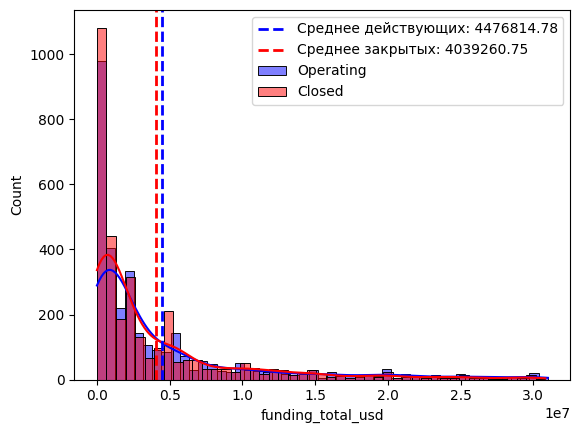

In [59]:
stats_contrast(operating_company, closed_company, 'funding_total_usd')

##### Проверим вторую гипотезу:

In [60]:
alpha = 0.05 # установим уровень статистической значимости в 5%
result = st.ttest_ind(operating_company['funding_rounds']
                      ,closed_company['funding_rounds']
                      ,alternative='greater')
print('p_value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем H0 в пользу H1')
else:
    print('Нет оснований отвергать H0')

p_value: 1.9440338493632746e-16
Отвергаем H0 в пользу H1


**Итого**: Отвергаем H0 в пользу H1 - это значит, что cреднее значение количества раундов финансирования больше в тех компаниях, которые действуют до сих пор.

Посмотрим на распределения funding_rounds для действующих и закрытых компаний.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


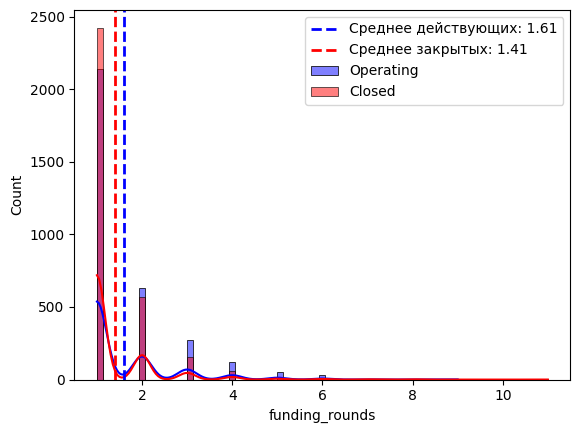

In [61]:
stats_contrast(operating_company, closed_company, 'funding_rounds')

**Вывод:** на основе статистических тестов определено, что успешные стартапы в среднем имеют большую сумму финансирования и большее количество инвестиционных раундов.

#### Найдём различия между действующими и закрытыми компаниями в категориальных признаках

Изучим популярные country_code в действующих и закрытых стартапах.

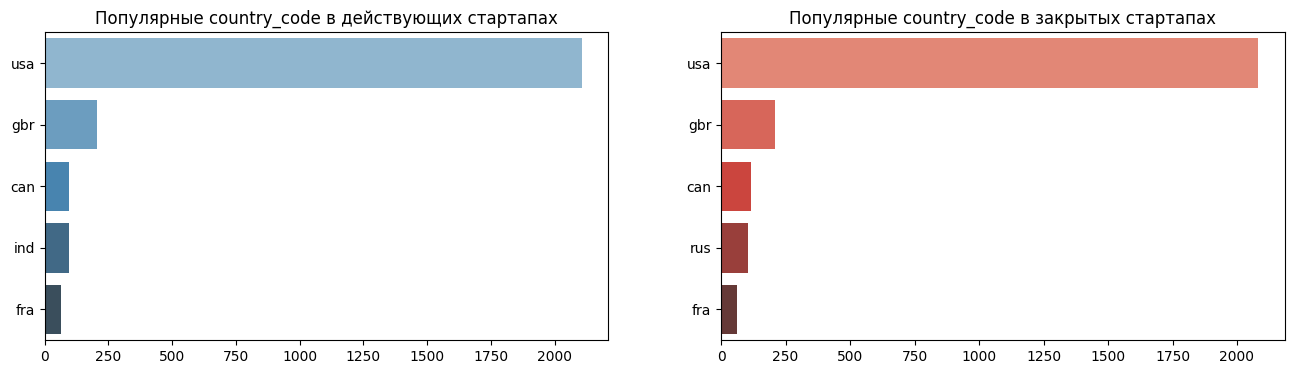

In [62]:
eda_category(operating_company, closed_company, 'country_code', contrast=1)

**Итого:** в закрытых и действующих стартапах лидирующий код страны "USA", какие-либо различия начинаются с 3-го места, но это уже малозначные категории.

Изучим популярные state_code в действующих и закрытых стартапах.

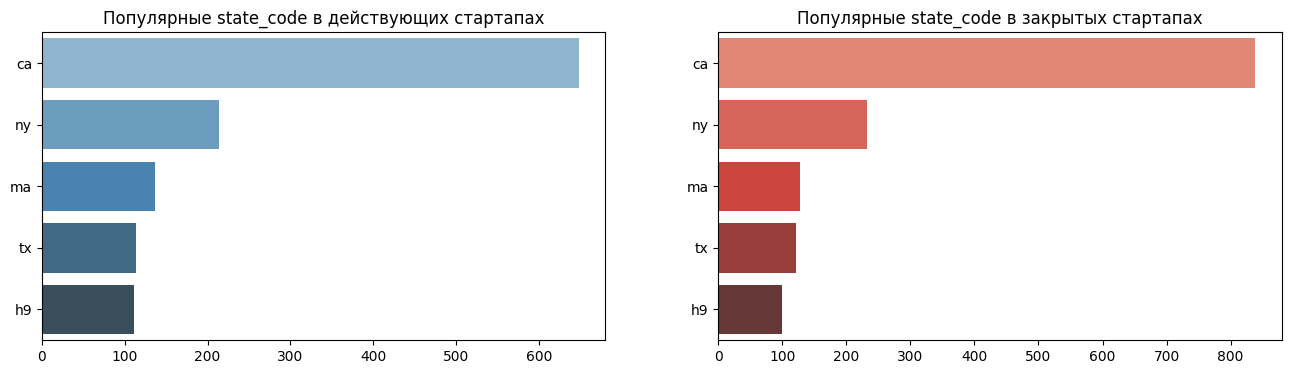

In [63]:
eda_category(operating_company, closed_company, 'state_code', contrast=1)

**Итого:** в закрытых и открытых стартапах на первом месте регион "CA". Заметим, что категории в двух случаях одни и те же, просто меняются местами при закрытом и действующем стартапе.

Изучим популярные region в действующих и закрытых стартапах.

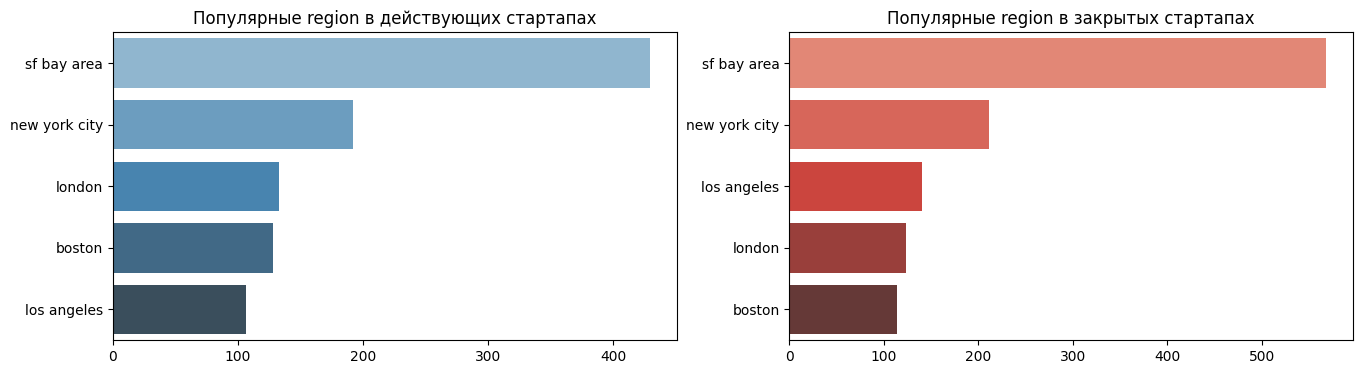

In [64]:
eda_category(operating_company, closed_company, 'region', contrast=1)

**Итого:** нечто похожее габлюдали выше - топ-2 категории одинаковы, а начиная с третьей просто меняются местами. Заметим, что в действующих стартапах Los Angeles занимаем пятое место, а в закрытых третье.

Изучим популярные city в действующих и закрытых стартапах.

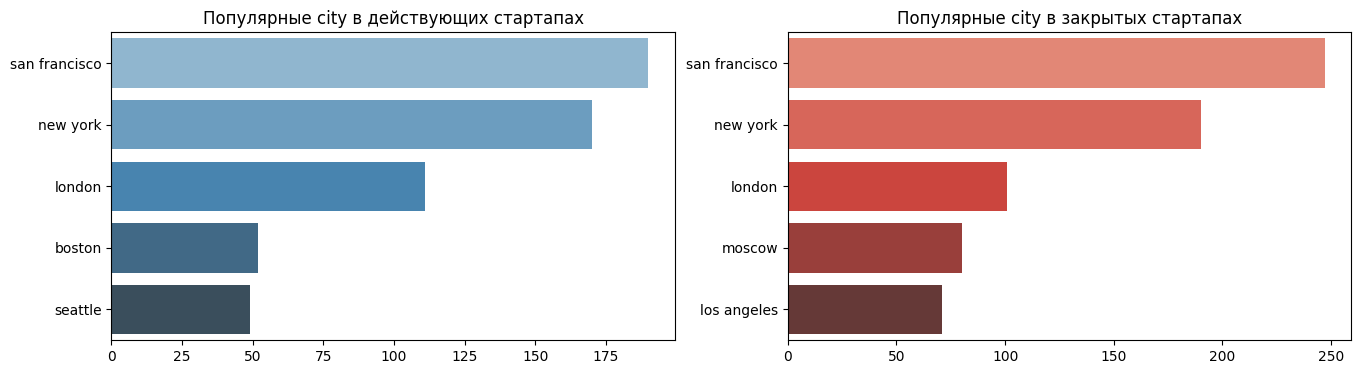

In [65]:
eda_category(operating_company, closed_company, 'city', contrast=1)

**Итого:** в топ-3 городов для открытия стартапа входят San Francisco, New York, London, причём в топ-3 действующих и закрытых стартапов. Примичательно, что на 4ом месте закрытых стартапов расположилась Москва. Вероятно, это из-за того, что на 4ом месте в рейтинге закрытых компании по country_code стоит "RUS".

**Вывод по успешности стартапа:** как оказалось, место открытия стартапа мало зависит от его успешности - на первых позициях по рейтингу действующих и закрытых компаний стоят одни и те же страны, регионы и города. Иначе обстоят дела с суммами инвестиций и количеством инвестиционных раундов - чем больше того и другого, тем более вероятно, что стартап будет успешным.

## Создадим новые признаки

### Извлечём новые признаки из временных данных
Временные данные весьма полезны и просто избавляться от неблагоразумно. Извлечём из них следующие признаки:  
1) Количество дней между датой открытия и датой закрытия (или датой выгрузки данных)  
2) Количество дней между открытием и первым раундом финансирования  
3) Количество дней между открытием и последним раундом финансирования  
4) Количество дней между первым и последним раундом финансирования  
5) Количество дней между закрытием (или датой выгрузки) и первым раундом финансирования  
6) Количество дней между закрытием (или датой выгрузки) и последним раундом финансирования  
Все эти признаки необходимо создать в обычном датасете, предобработанном и тестовом.

In [66]:
#Количество дней между датой открытия и датой закрытия (или датой выгрузки данных)
data_train['exist'] = data_train['closed_at'] - data_train['founded_at']
data_train['exist'] = data_train['exist'].dt.days

prep_data_train['exist'] = prep_data_train['closed_at'] - prep_data_train['founded_at']
prep_data_train['exist'] = prep_data_train['exist'].dt.days

data_test['exist'] = data_test['closed_at'] - data_test['founded_at']
data_test['exist'] = data_test['exist'].dt.days

In [67]:
#Количество дней между открытием и первым раундом финансирования
data_train['open_to_first_round'] = data_train['first_funding_at'] - data_train['founded_at']
data_train['open_to_first_round'] = data_train['open_to_first_round'].dt.days

prep_data_train['open_to_first_round'] = prep_data_train['first_funding_at'] \
                                         - prep_data_train['founded_at']
prep_data_train['open_to_first_round'] = prep_data_train['open_to_first_round'].dt.days

data_test['open_to_first_round'] = data_test['first_funding_at'] - data_test['founded_at']
data_test['open_to_first_round'] = data_test['open_to_first_round'].dt.days

In [68]:
#Количество дней между открытием и последним раундом финансирования
data_train['open_to_last_round'] = data_train['last_funding_at'] - data_train['founded_at']
data_train['open_to_last_round'] = data_train['open_to_last_round'].dt.days

prep_data_train['open_to_last_round'] = prep_data_train['last_funding_at'] \
                                        - prep_data_train['founded_at']
prep_data_train['open_to_last_round'] = prep_data_train['open_to_last_round'].dt.days

data_test['open_to_last_round'] = data_test['last_funding_at'] - data_test['founded_at']
data_test['open_to_last_round'] = data_test['open_to_last_round'].dt.days

In [69]:
#Количество дней между первым и последним раундом финансирования
data_train['first_to_last_round'] = data_train['last_funding_at'] - data_train['first_funding_at']
data_train['first_to_last_round'] = data_train['first_to_last_round'].dt.days

prep_data_train['first_to_last_round'] = prep_data_train['last_funding_at'] \
                                          - prep_data_train['first_funding_at']
prep_data_train['first_to_last_round'] = prep_data_train['first_to_last_round'].dt.days

data_test['first_to_last_round'] = data_test['last_funding_at'] - data_test['first_funding_at']
data_test['first_to_last_round'] = data_test['first_to_last_round'].dt.days

In [70]:
#Количество дней между закрытием (или датой выгрузки) и первым раундом финансирования
data_train['close_to_first_round'] = data_train['closed_at'] - data_train['first_funding_at']
data_train['close_to_first_round'] = data_train['close_to_first_round'].dt.days

prep_data_train['close_to_first_round'] = prep_data_train['closed_at'] \
                                          - prep_data_train['first_funding_at']
prep_data_train['close_to_first_round'] = prep_data_train['close_to_first_round'].dt.days

data_test['close_to_first_round'] = data_test['closed_at'] - data_test['first_funding_at']
data_test['close_to_first_round'] = data_test['close_to_first_round'].dt.days

In [71]:
#Количество дней между закрытием (или датой выгрузки) и последним раундом финансирования
data_train['close_to_last_round'] = data_train['closed_at'] - data_train['last_funding_at']
data_train['close_to_last_round'] = data_train['close_to_last_round'].dt.days

prep_data_train['close_to_last_round'] = prep_data_train['closed_at'] \
                                         - prep_data_train['last_funding_at']
prep_data_train['close_to_last_round'] = prep_data_train['close_to_last_round'].dt.days

data_test['close_to_last_round'] = data_test['closed_at'] - data_test['last_funding_at']
data_test['close_to_last_round'] = data_test['close_to_last_round'].dt.days

In [72]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,exist,open_to_first_round,open_to_last_round,first_to_last_round,close_to_first_round,close_to_last_round
0,lunchgate,online reservations|restaurants,828626.00,operating,che,25,zurich,zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01,2748,311.00,1621,1310.00,2437.00,1127
1,earlens,manufacturing|medical|medical devices,42935019.00,operating,usa,ca,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,1949.00,3342,1393.00,2799.00,1406
2,reviva pharmaceuticals,biotechnology,35456381.00,operating,usa,ca,sf bay area,san jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,2423.00,3104,681.00,1960.00,1279
4,wiretough cylinders,manufacturing,1364640.00,operating,usa,va,va - other,bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01,2712,551.00,551,0.00,2161.00,2161
5,connected sports ventures,mobile,4300000.00,operating,usa,nj,newark,princeton,1,2011-04-21,2012-11-12,2012-11-12,2018-01-01,2447,571.00,571,0.00,1876.00,1876


Проверим созданные признаки на выбросы и аномалии. Начнём с необработанного тренировочного датасета.

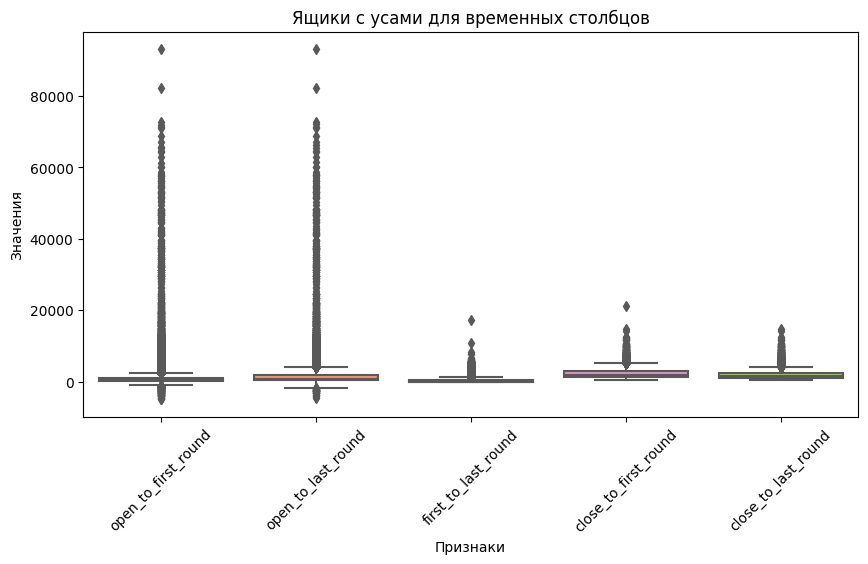

In [73]:
boxplot_multiple_columns(data_train[['open_to_first_round',\
                   'open_to_last_round',\
                   'first_to_last_round',\
                   'close_to_first_round',\
                   'close_to_last_round']])

**Итого:** обратим внимание, что в признаках open_to_first_round (количество дней между открытием компании и первым раундом финансирования) и open_to_last_round (количество дней между открытием компании) содержатся отрицательные значения, т.е раунды финансирования прошли раньше, чем компания была создана. Причём такая аномалия содержится только в двух этих столбцах, в других временных столбцах таких значений нет.

Изучим обработанный тренировочный датасет.

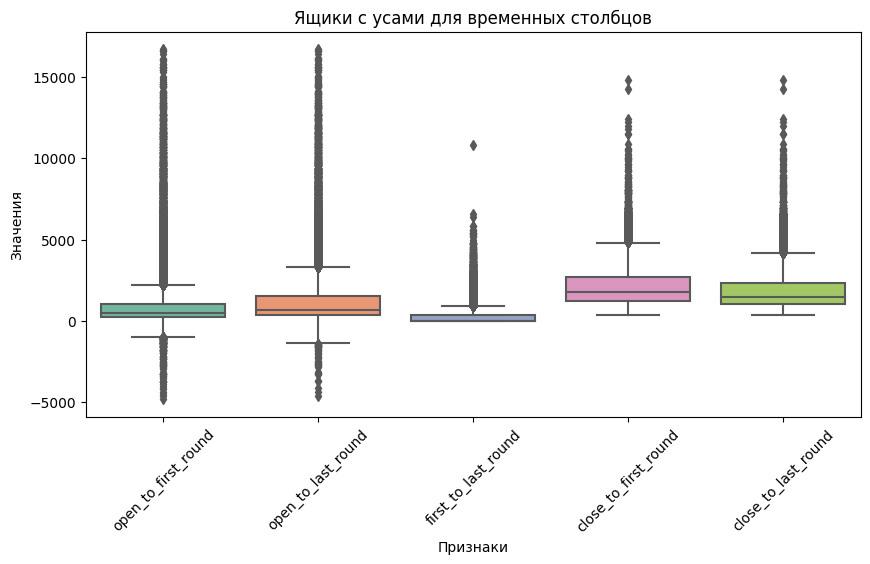

In [74]:
boxplot_multiple_columns(prep_data_train[['open_to_first_round',\
                   'open_to_last_round',\
                   'first_to_last_round',\
                   'close_to_first_round',\
                   'close_to_last_round']])

**Итого**: аналогичная ситуация наблюдается и в предобработанном датасете - существуют компании, в которых раунды финансирования проводились до того, как компания была создана.

В предобработанном датасете избавимся от этих аномалий.

In [75]:
prep_data_train = prep_data_train[prep_data_train['open_to_first_round']>=0]
prep_data_train = prep_data_train[prep_data_train['open_to_last_round']>=0]

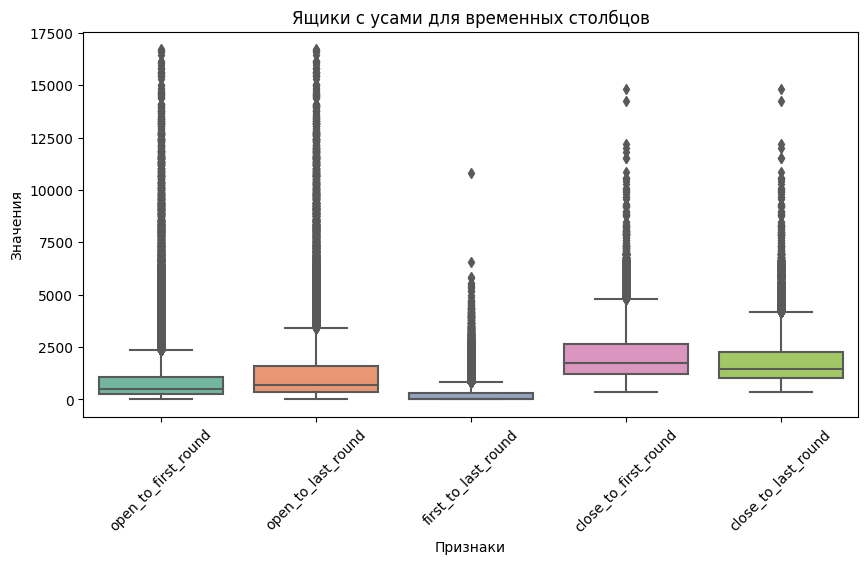

In [76]:
boxplot_multiple_columns(prep_data_train[['open_to_first_round',\
                   'open_to_last_round',\
                   'first_to_last_round',\
                   'close_to_first_round',\
                   'close_to_last_round']])

**Итого:** в предобработанном датасете аномалия была удалена.

Изучим тестовый датасет.

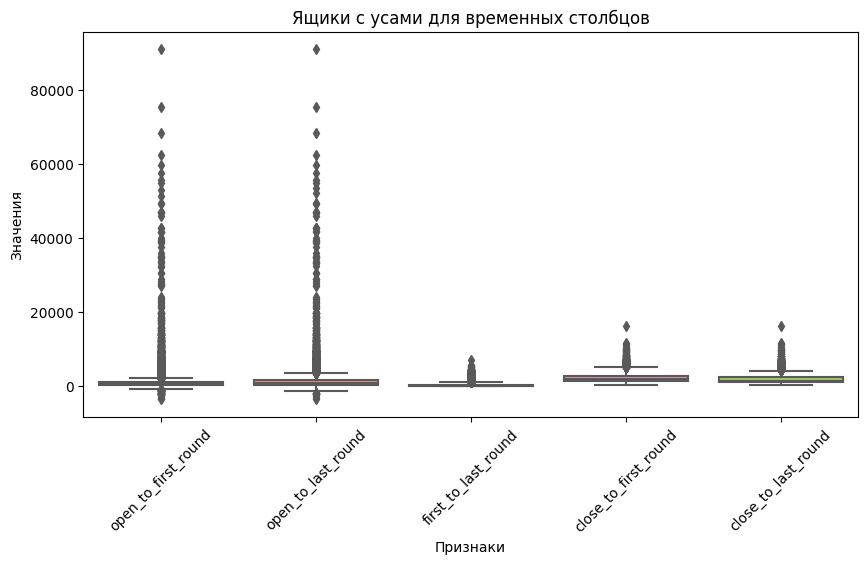

In [77]:
boxplot_multiple_columns(data_test[['open_to_first_round',\
                   'open_to_last_round',\
                   'first_to_last_round',\
                   'close_to_first_round',\
                   'close_to_last_round']])

**Итого:** в тестовых данных содержится та же аномалия. Заметим, что по структуре ящиков с усами временных признаков тестовый датасет очень похож на необработанных тренировочный.

**Вывод:** извлечены новые признаки из временных данных. Была обнаружена аномалия, связання с несостыковкой дат

### Извлечём новые признаки из категориальных столбцов  
В частности подберём подходы к данным, где много уникальных значений и где проводить One Hot Encoding будет нецелесообразно. Обратим на группу признаков и один целостный признак:  
1) Группа, связанная с географическим положением (country_code, state_code, region, city) - как работать с такими признаками мы частично определелили в пункте "Изучим категориальные столбцы" - оставим уникальные значение только нескольких популярных категорий, а малочисленные категории поместим в категорию "другое". Под "другим" будем понимать нулевое значение во всех категориях, дабы избежать мультиколлинеарности;  
2) Список категорий, к которым относится стартап (category_list) - содержит много уникальных значений. Для этого признака будет совершенно другой подход. Изучим какую-то часть этих уникальных значений и постараемся разбить все микро-темы на более глобальные, используя ключевые слова. То есть возьмём примерно 8-10 сфер деятельности, и в каждом описании поищем их. Получится что-то вроде One Hot Encoding, но в одном признаке может быть несколько единиц из-за смежности двух областей (например, описание одной компании может гласить: 'Medical|Health|Artificial Intelligence' - т.е единицы по нашей идее должны стоять в категориях Medical и IT)

#### Начнём с признаков географического положения. 
Основываясь на изучении категориальных признаках (см. выше) поделим категории:  
1) country_code поделим на USA и другое (в итоге получится новый признак country_code, в котором будет только 0 или 1);  
2) state_code поделим на CA, NY, MA и другое;  
3) region поделим на SF Bay Area, New York City, Boston, London, Los Angeles, Seattle и другое;  
4) city поделим на San Francisco, New York, London и другое

In [78]:
#Поделим country_code
data_train['country_USA'] = data_train['country_code'].apply(lambda x: 1 if x=='usa' else 0)
prep_data_train['country_USA'] = prep_data_train['country_code'].apply(lambda x: 1 if x=='usa' else 0)
data_test['country_USA'] = data_test['country_code'].apply(lambda x: 1 if x=='usa' else 0)

#Поделим state_code:
list_state_codes = ['ca', 'ny', 'ma']
for code in list_state_codes:
    data_train[code] = data_train['state_code'].apply(lambda x: 1 if x==code else 0)
    prep_data_train[code] = prep_data_train['state_code'].apply(lambda x: 1 if x==code else 0)
    data_test[code] = data_test['state_code'].apply(lambda x: 1 if x==code else 0)

#Поделим region:
list_regions = ['sf bay area', 'new york city', 'boston', 'london', 'los angeles', 'seattle']
for reg in list_regions:
    s = '_reg'
    data_train[reg+s] = data_train['region'].apply(lambda x: 1 if x==reg else 0)
    prep_data_train[reg+s] = prep_data_train['region'].apply(lambda x: 1 if x==reg else 0)
    data_test[reg+s] = data_test['region'].apply(lambda x: 1 if x==reg else 0)
    
#Поделим city:
list_cities = ['san francisco', 'new york', 'london']
for city in list_cities:
    s = '_city'
    data_train[city+s] = data_train['city'].apply(lambda x: 1 if x==city else 0)
    prep_data_train[city+s] = prep_data_train['city'].apply(lambda x: 1 if x==city else 0)
    data_test[city+s] = data_test['city'].apply(lambda x: 1 if x==city else 0)

Посмотрим на созданные признаки.

In [79]:
data_train.head().T

,0,1,2,4,5
name,lunchgate,earlens,reviva pharmaceuticals,wiretough cylinders,connected sports ventures
category_list,online reservations|restaurants,manufacturing|medical|medical devices,biotechnology,manufacturing,mobile
funding_total_usd,828626.00,42935019.00,35456381.00,1364640.00,4300000.00
status,operating,operating,operating,operating,operating
country_code,che,usa,usa,usa,usa
state_code,25,ca,ca,va,nj
region,zurich,sf bay area,sf bay area,va - other,newark
city,zürich,redwood city,san jose,bristol,princeton
funding_rounds,2,4,3,1,1
founded_at,2010-06-24 00:00:00,2005-01-01 00:00:00,2006-01-01 00:00:00,2010-07-30 00:00:00,2011-04-21 00:00:00


**Итого**: созданы новые признаки географического положения

#### Создадим новые признаки на основе списка категорий компании
Для начала посмотрим на 200 категорий в этом признаке и выделим несколько базовых (этого должно хватить)  
*p.s: закомментируем код, для более быстрого пролистывания ноутбука*

In [80]:
'''
category_list = data_train['category_list'].unique()
k=1
for category in category_list:
    k+=1
    print(category)
    if k > 200:
        break
'''

"\ncategory_list = data_train['category_list'].unique()\nk=1\nfor category in category_list:\n    k+=1\n    print(category)\n    if k > 200:\n        break\n"

Внимательно изучив категории выше, можно выделить несколько базовых:  
1) **Medical** (Medical, Health Care, Healthcare Services, Medical Devices, Health and Wellness, Biotechnology, Pharmaceuticals)  
2) **Media** (Media, Social Media, Digital Media, Social Network Media, Promotional, Promotion, Public, Advertising, Content)  
3) **Services** (Services, Consulting, Insurance Companies, Travel, Tourism, Rental, SaaS, Promotion, B2B, Outsourcing, Reservations, Transportation)  
4) **Commerce**  (E-Commerce, Commerce, Online Shopping, Shopping, Retail, Businesses, Sales, Consumer, Marketplaces)  
5) **IT** (Analytics, Big Data, Artificial Intelligence, Information, Web, SEO, IT, Internet, Cybersecurity, Data)  
6) **Software** (Computers, Software Developer Tools, Productivity Software, Software, Apps, 3D, Android, iOS, iPad)  
7) **Finance** (Finance Technology, FinTech, Pay, Bitcoin, Cryptocurrency, Banking)  
8) **Industrial** (Enterprises, Robotics, Manufacturing, Semiconductors, Technology, Materials, Wearables, Industrial, Lighting, Energy, Local Businesses, Businesses, Electronics, Nanotechnology, Engineering, Optical, Sensors)  
9) **Entertainment** (Restaurants, Games, Food, Video, Music, Film, Education, Learning, Study, Fitness, Sport)

Теперь создадим столбцы с данными категориями. Все категории записывать не будем, а запишем именно key-words категории (бессмысленно искать категории Health Care, Healthcare Services, если можно просто найти слово Health).

Создадим списки с key words:

In [81]:
medical_list = ['medical','health','wellness', 'biotechnology', 'pharmaceuticals']

media_list = ['media', 'network' , 'promotional', 'promotion', 'public', 'advertising', 'content']

services_list = ['services', 'consulting', 'insurance companies', 'travel',
                 'tourism', 'rental', 'saas', 'promotion', 'b2b',
                 'outsourcing', 'reservations', 'transportation']

commerce_list = ['commerce', 'shopping', 'retail', 'businesses', 'sales', 'consumer', 'marketplaces']

it_list = ['analytics', 'artificial Intelligence', 'information',
           'web', 'seo', 'it', 'internet', 'cybersecurity', 'data']

software_list = ['computers', 'software', 'apps', '3d', 'android', 'ios', 'ipad']

finance_list = ['finance', 'fintech', 'pay', 'bitcoin', 'cryptocurrency', 'banking']

industrial_list = ['enterprises', 'robotics', 'manufacturing', 'semiconductors',
                   'technology', 'materials', 'wearables', 'industrial', 'lighting',
                   'energy', 'businesses', 'electronics', 'nanotechnology',
                   'engineering', 'optical', 'sensors']

entertainment_list = ['restaurants', 'game', 'food', 'video', 'music', 'film',
                      'education', 'learning', 'fitness', 'sport']

Создадим новые признаки.

In [82]:
# Создадим признак is_medical
data_train['is_medical'] = data_train["category_list"]\
                           .str.contains("|".join(medical_list)).astype(float)
prep_data_train['is_medical'] = prep_data_train["category_list"]\
                           .str.contains("|".join(medical_list)).astype(float)
data_test['is_medical'] = data_test["category_list"]\
                           .str.contains("|".join(medical_list)).astype(float)

In [83]:
# Создадим признак is_media
data_train['is_media'] = data_train["category_list"]\
                           .str.contains("|".join(media_list)).astype(float)
prep_data_train['is_media'] = prep_data_train["category_list"]\
                           .str.contains("|".join(media_list)).astype(float)
data_test['is_media'] = data_test["category_list"]\
                           .str.contains("|".join(media_list)).astype(float)

In [84]:
#Создадим признак is_services services_list
data_train['is_services'] = data_train["category_list"]\
                           .str.contains("|".join(services_list)).astype(float)
prep_data_train['is_services'] = prep_data_train["category_list"]\
                           .str.contains("|".join(services_list)).astype(float)
data_test['is_services'] = data_test["category_list"]\
                           .str.contains("|".join(services_list)).astype(float)

In [85]:
# Создадим признак is_commerce
data_train['is_commerce'] = data_train["category_list"]\
                           .str.contains("|".join(commerce_list)).astype(float)
prep_data_train['is_commerce'] = prep_data_train["category_list"]\
                           .str.contains("|".join(commerce_list)).astype(float)
data_test['is_commerce'] = data_test["category_list"]\
                           .str.contains("|".join(commerce_list)).astype(float)

In [86]:
# Создадим признак is_it
data_train['is_it'] = data_train["category_list"]\
                           .str.contains("|".join(it_list)).astype(float)
prep_data_train['is_it'] = prep_data_train["category_list"]\
                           .str.contains("|".join(it_list)).astype(float)
data_test['is_it'] = data_test["category_list"]\
                           .str.contains("|".join(it_list)).astype(float)

In [87]:
# Создадим признак is_software
data_train['is_software'] = data_train["category_list"]\
                           .str.contains("|".join(software_list)).astype(float)
prep_data_train['is_software'] = prep_data_train["category_list"]\
                           .str.contains("|".join(software_list)).astype(float)
data_test['is_software'] = data_test["category_list"]\
                           .str.contains("|".join(software_list)).astype(float)

In [88]:
# Создадим признак is_finance
data_train['is_finance'] = data_train["category_list"]\
                           .str.contains("|".join(finance_list)).astype(float)
prep_data_train['is_finance'] = prep_data_train["category_list"]\
                           .str.contains("|".join(finance_list)).astype(float)
data_test['is_finance'] = data_test["category_list"]\
                           .str.contains("|".join(finance_list)).astype(float)

In [89]:
# Создадим признак is_industrial
data_train['is_industrial'] = data_train["category_list"]\
                           .str.contains("|".join(industrial_list)).astype(float)
prep_data_train['is_industrial'] = prep_data_train["category_list"]\
                           .str.contains("|".join(industrial_list)).astype(float)
data_test['is_industrial'] = data_test["category_list"]\
                           .str.contains("|".join(industrial_list)).astype(float)

In [90]:
# Создадим признак is_entertainment
data_train['is_entertainment'] = data_train["category_list"]\
                           .str.contains("|".join(entertainment_list)).astype(float)
prep_data_train['is_entertainment'] = prep_data_train["category_list"]\
                           .str.contains("|".join(entertainment_list)).astype(float)
data_test['is_entertainment'] = data_test["category_list"]\
                           .str.contains("|".join(entertainment_list)).astype(float)

Посмотрим на результат.

In [91]:
data_train[['category_list','is_medical', 'is_services', 'is_media',\
            'is_commerce','is_it', 'is_software',\
            'is_finance', 'is_industrial', 'is_entertainment']].head(20)

,category_list,is_medical,is_services,is_media,is_commerce,is_it,is_software,is_finance,is_industrial,is_entertainment
0,online reservations|restaurants,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,manufacturing|medical|medical devices,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,biotechnology,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,manufacturing,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
5,mobile,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,analytics|business analytics|social crm|social...,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
7,software,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
8,biotechnology,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
9,semiconductors,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
10,software,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


**Итого:** получилось то что надо, новые признаки созданы

**Вывод**: созданы новые признаки на основе категориальных столбцов

## Проведём анализ на мультиколлинеарность

### Определим виды распределений числовых столбцов
Для верного проведения анализа на мультиколлинеарность необходимо определить виды распределений (нормальное/ненормальное) числовых признаков.

Из EDA выше знаем, что признаки funding_total_usd и funding_rounds ненормально распределены. Узнаем, распределены ли нормально созданные нами признаки.

In [92]:
cols_for_analysis = ['open_to_first_round', 'open_to_last_round','first_to_last_round', 
                     'close_to_first_round', 'close_to_last_round', 'exist']

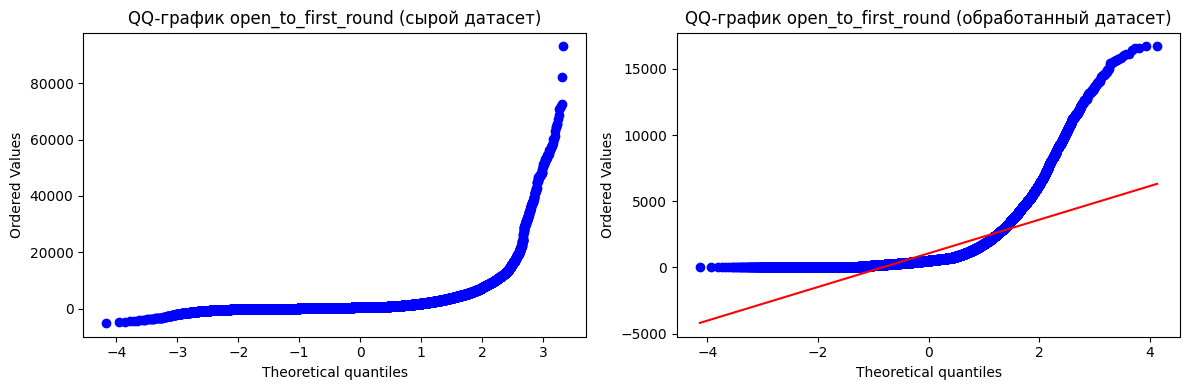

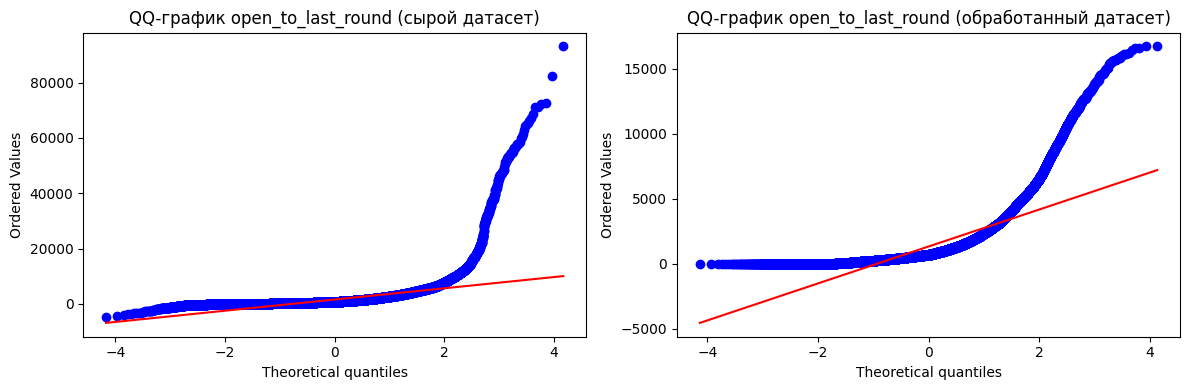

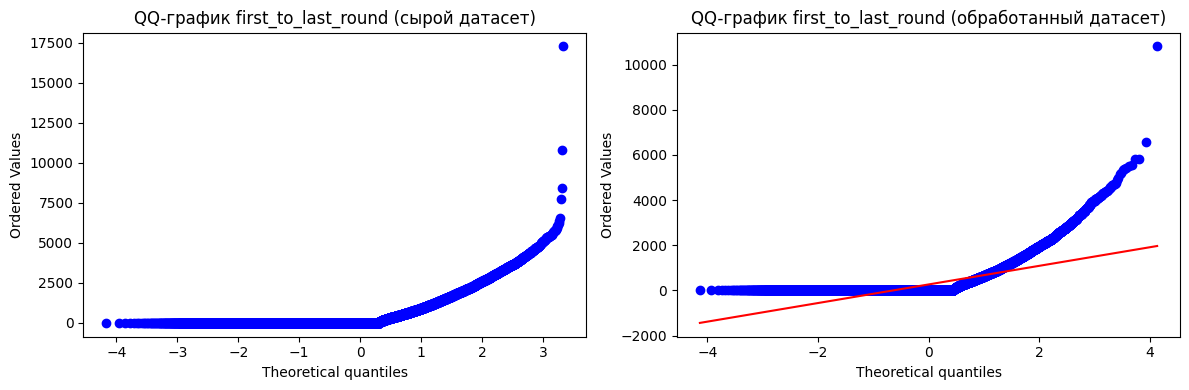

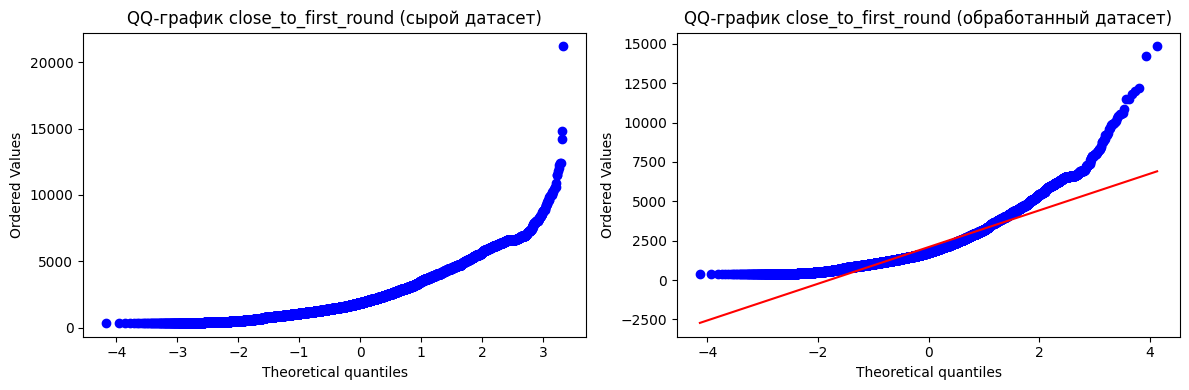

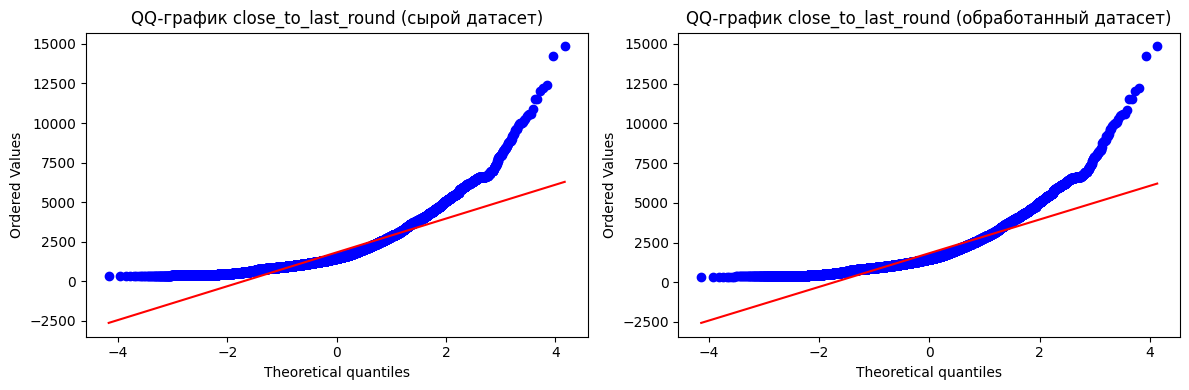

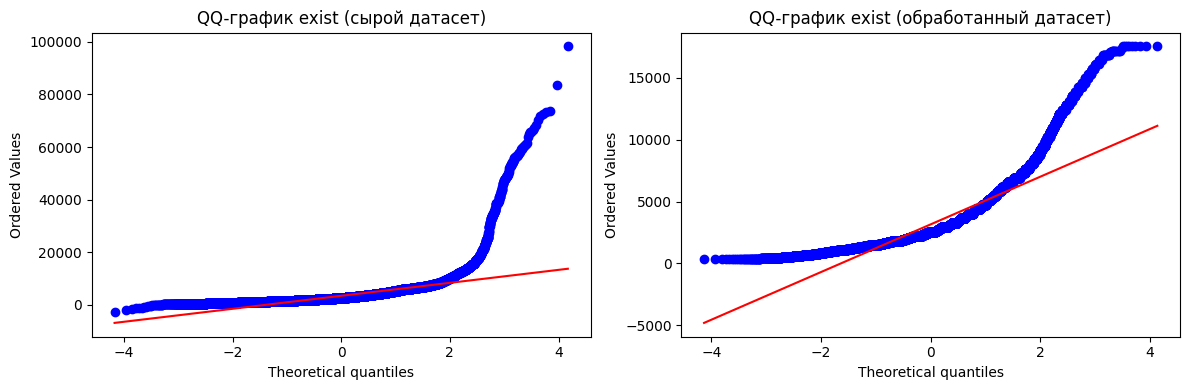

In [93]:
for col in cols_for_analysis:
    qq_plots_contrast(data_train, prep_data_train, col)

**Итого:** среди новых признаков нормально распределённых нет, поэтому при использовании корреляции phik в параметр interval_cols необходимо передать все эти признаки.

### Построим матрицу корреляций

Удалим признаки с большим количеством категорий и признаки с датами из предобработанного датасета.

In [94]:
data = prep_data_train.drop(['name', 'category_list', 'country_code', 
                        'state_code', 'region', 'city', 
                        'founded_at', 'first_funding_at', 'last_funding_at', 
                        'closed_at'], axis=1)

Отберём признаки с ненормальным распределением

In [95]:
interval_cols = ['funding_total_usd','funding_rounds', 'open_to_first_round', 
              'open_to_last_round','first_to_last_round', 'close_to_first_round', 
              'close_to_last_round', 'exist']

Построим матрицу корреляций

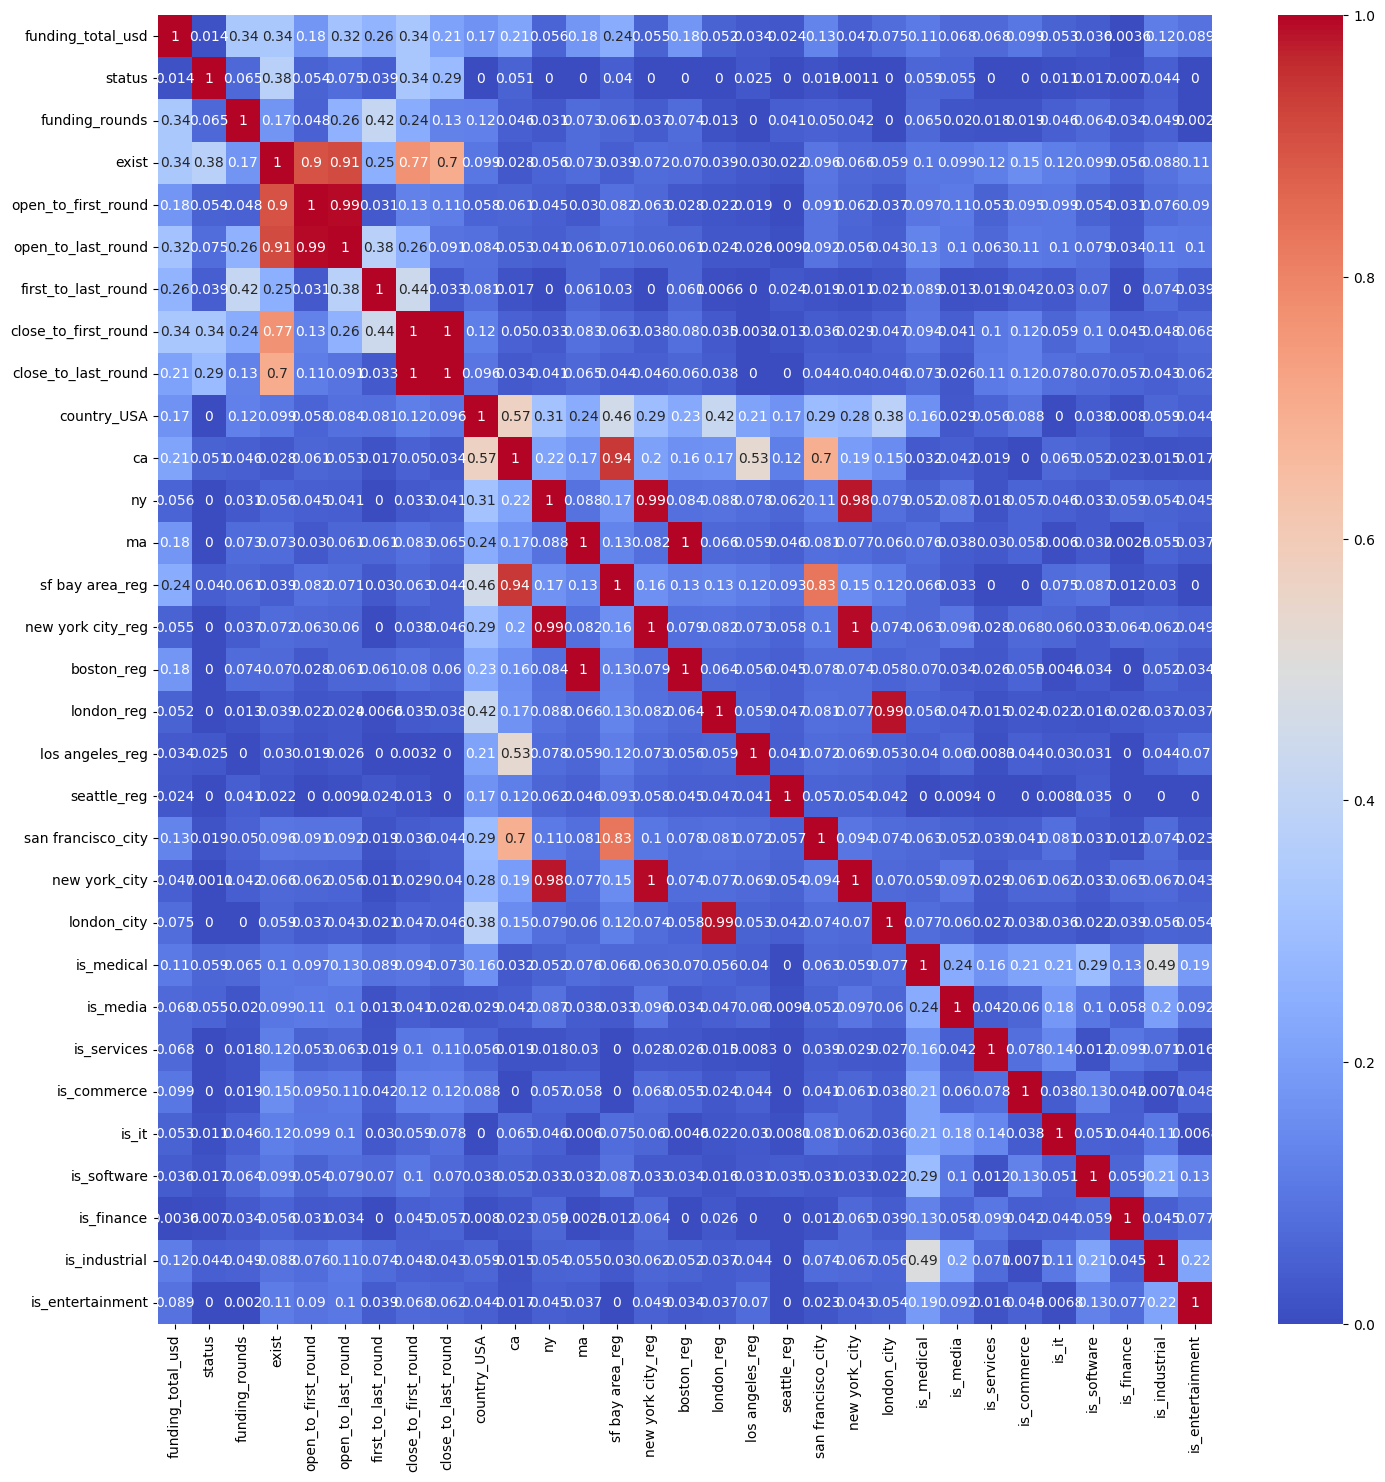

In [96]:
fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', ax=ax);

**Итого:** обнаружилась сильная мультиколлинеарность в созданных нами временных и географических признаках. Также обнаружились признаки, которые вообще не коррелируют с таргетом.

## Отбор признаков

Удалим признаки с нулевой корреляцией по отношению к таргету

In [97]:
data = data.drop(['country_USA', 'ny', 'ma', \
                  'new york city_reg', 'boston_reg', 'london_reg',\
                  'seattle_reg', 'new york_city', 'is_services', \
                  'is_commerce', 'is_entertainment'], axis=1)

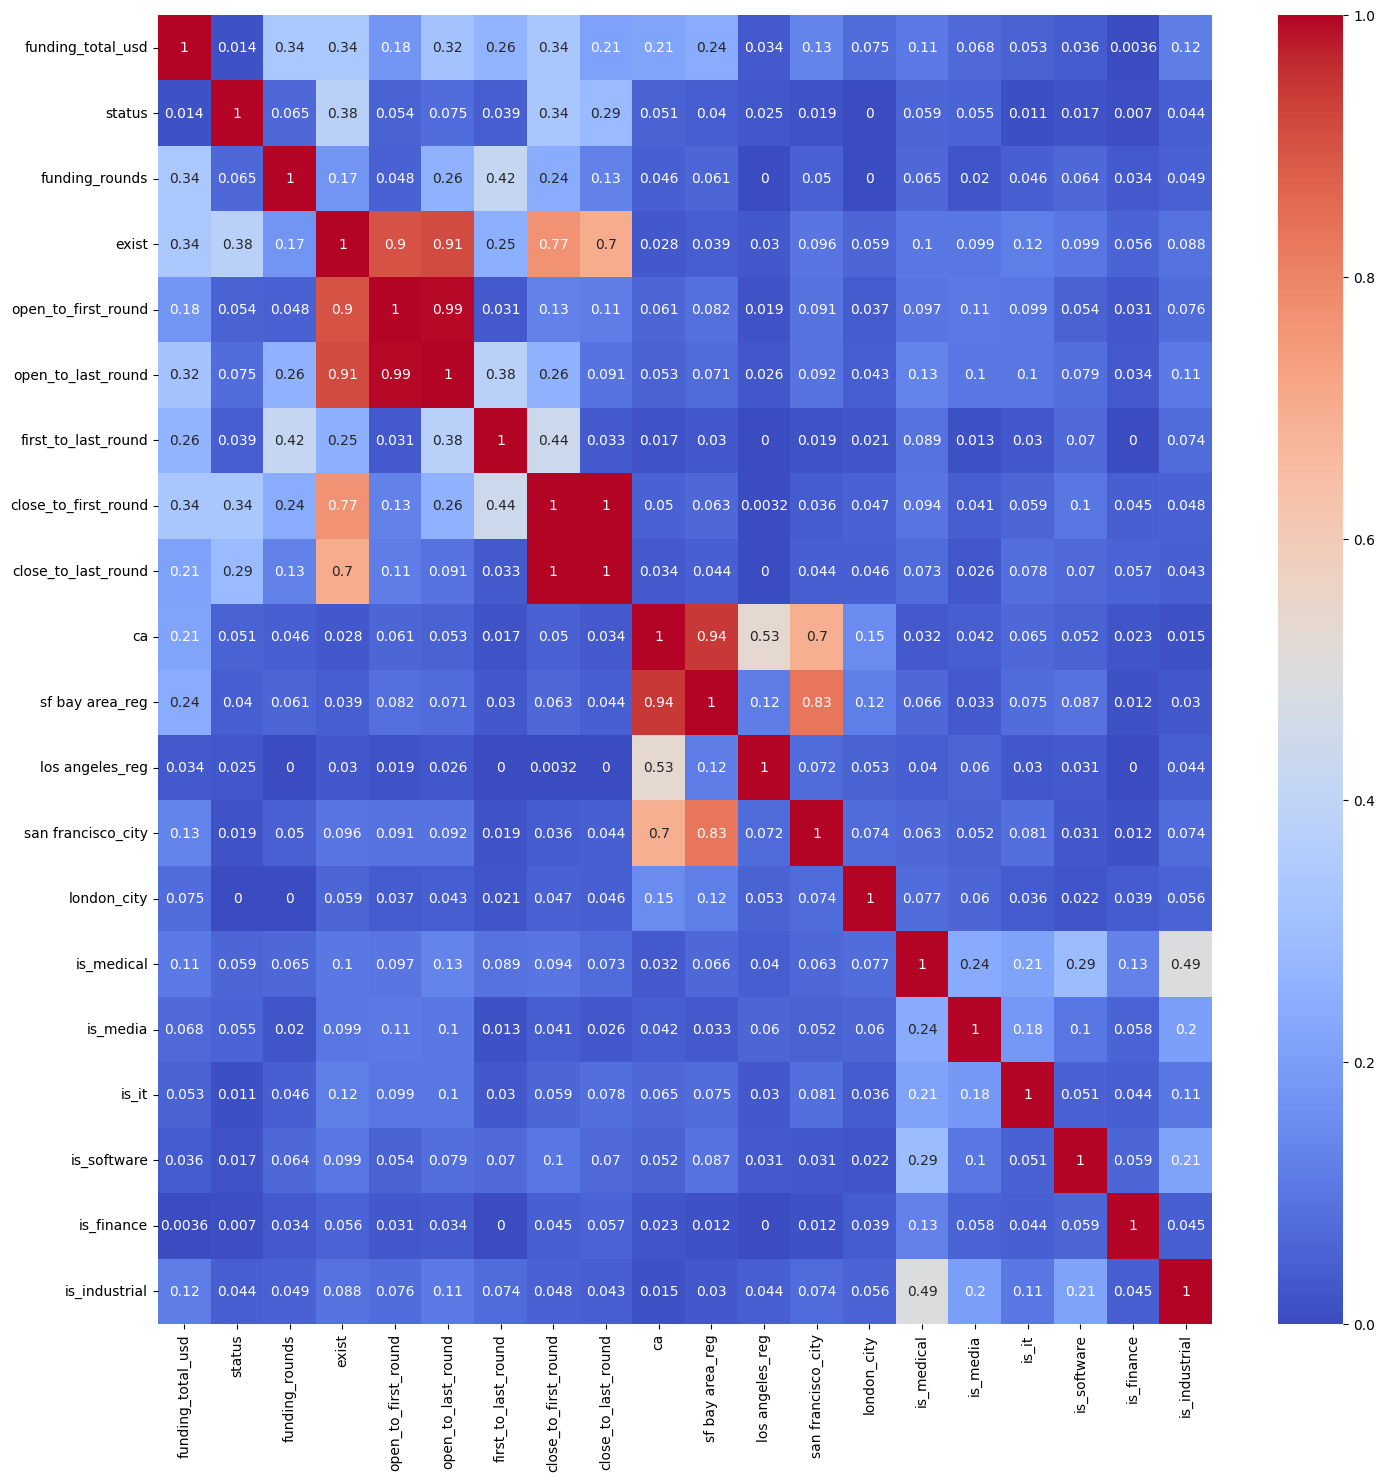

In [98]:
fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', ax=ax);

**Итого:** удалены признаки, не имеющие корреляции с таргетом

Теперь поработаем с мультиколлинеарными признаками 'open_to_first_round', 'open_to_last_round', 'first_to_last_round', 'close_to_first_round', 'close_to_last_round'.  
Дело в том, что они хранят довольно важную информацию о стартапе и присто избавляться из-за мультиколлинеарности не стоит. Заметим, что сильно коррелируют признаки 'open_to_first_round', 'open_to_last_round' (назовём их первой парой) и 'close_to_first_round', 'close_to_last_round' (назовём их второй парой), но между собой обе пары не коррелируют вообще.  
Так давайте просто перемножим признаки внутри каждой пары - так мы частино избавимся от мультиколлинеарности и заодно понизим размерность.  
Также удалим удалим признаки 'ca', 'sf bay area_reg'

In [99]:
data['open_to_first_last_round'] = data['open_to_first_round'] * data['open_to_last_round']
data['close_to_first_last_round'] = data['close_to_first_round'] * data['close_to_last_round']

# проделаем то же самое для тестовых данных:
data_test['open_to_first_last_round'] = data_test['open_to_first_round'] \
                                        * data_test['open_to_last_round']
data_test['close_to_first_last_round'] = data_test['close_to_first_round'] \
                                         * data_test['close_to_last_round']

Удалим признаки, которым нашли замену

In [100]:
data = data.drop(['open_to_first_round', 'open_to_last_round',\
                  'close_to_first_round', 'close_to_last_round', \
                  'ca', 'sf bay area_reg'], axis=1)

Построим матрицу корреляций ещё раз

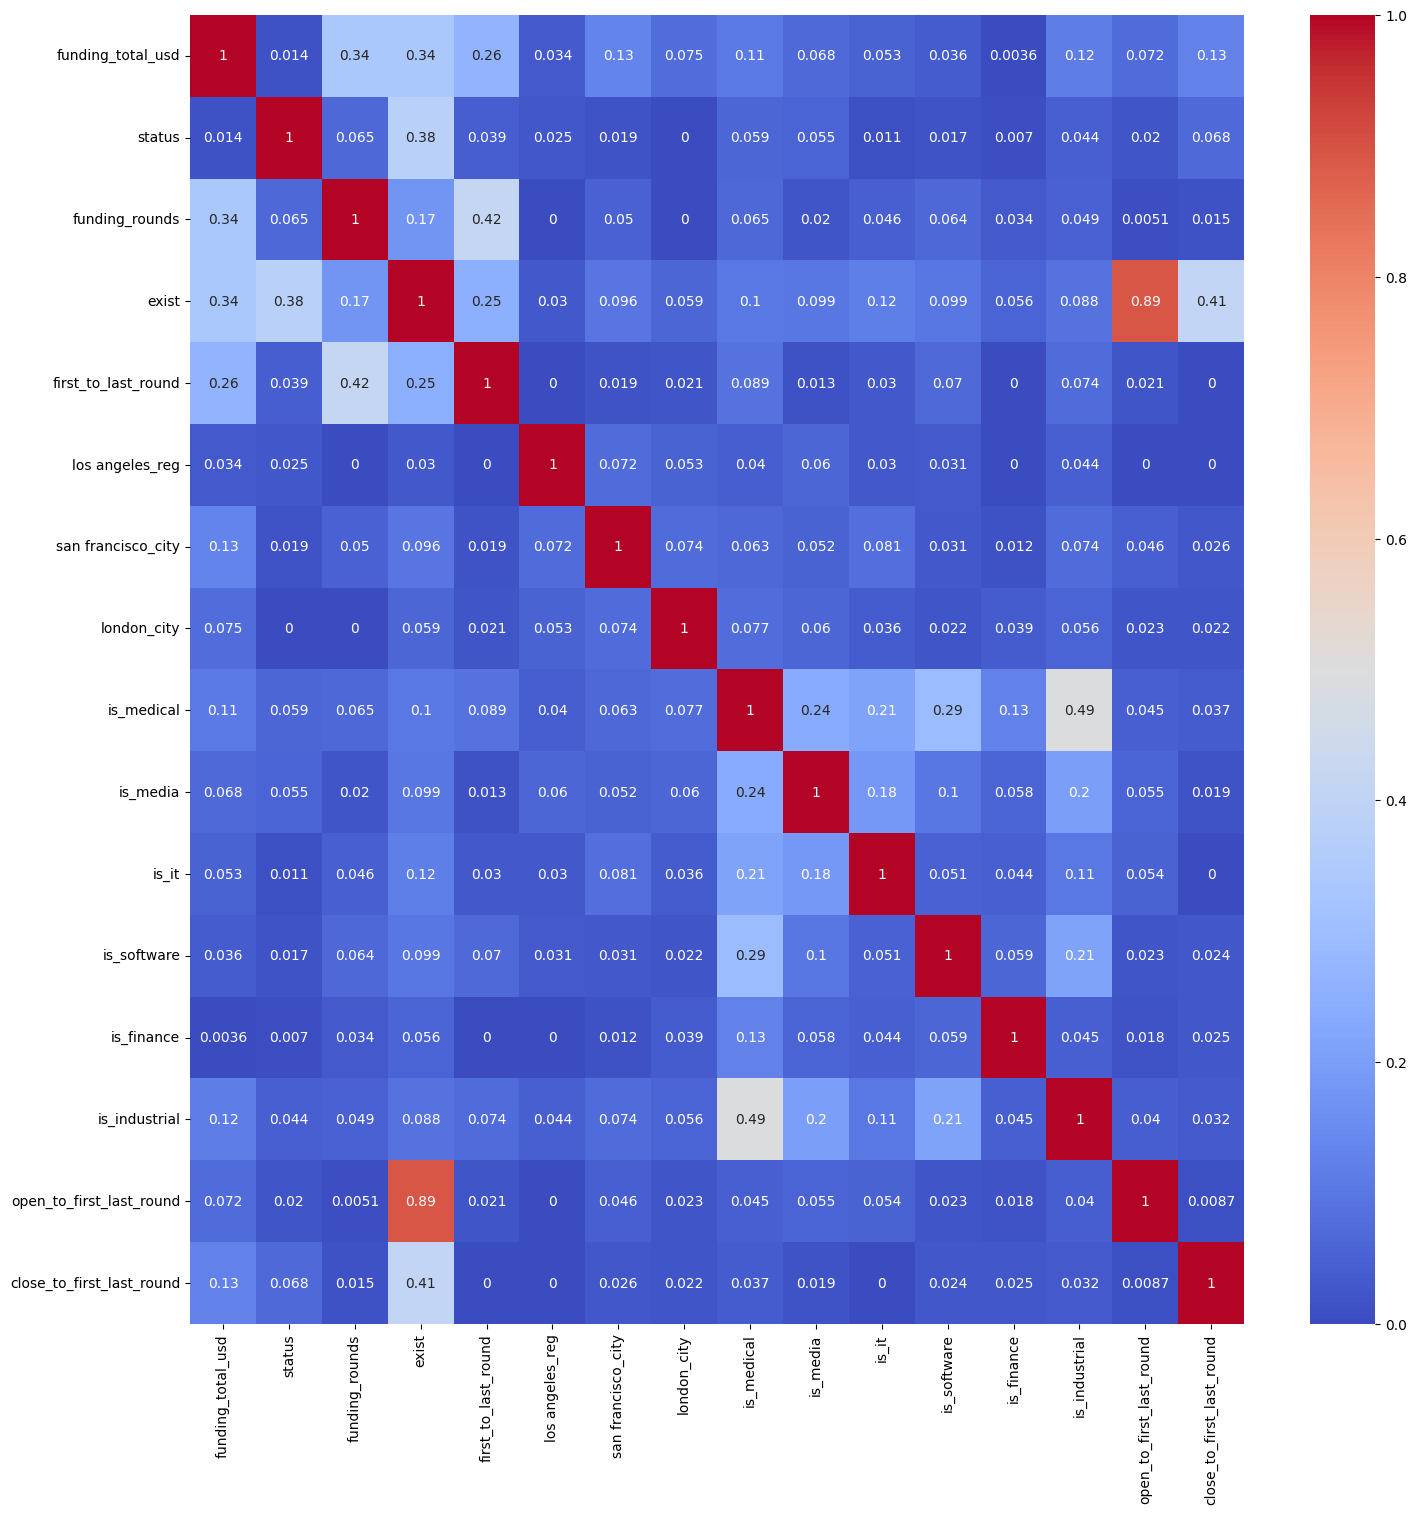

In [101]:
interval_cols = ['funding_total_usd','funding_rounds','exist',
                 'open_to_first_last_round', 'close_to_first_last_round', 'first_to_last_round']

fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', ax=ax);

Остался последняя пара мультиколлинеарных признаков - 'open_to_first_last_round' и 'exist'. Удалим тот, что имеет меньшую корреляцию с таргетом - 'open_to_first_last_round'

In [102]:
data = data.drop('open_to_first_last_round', axis=1)

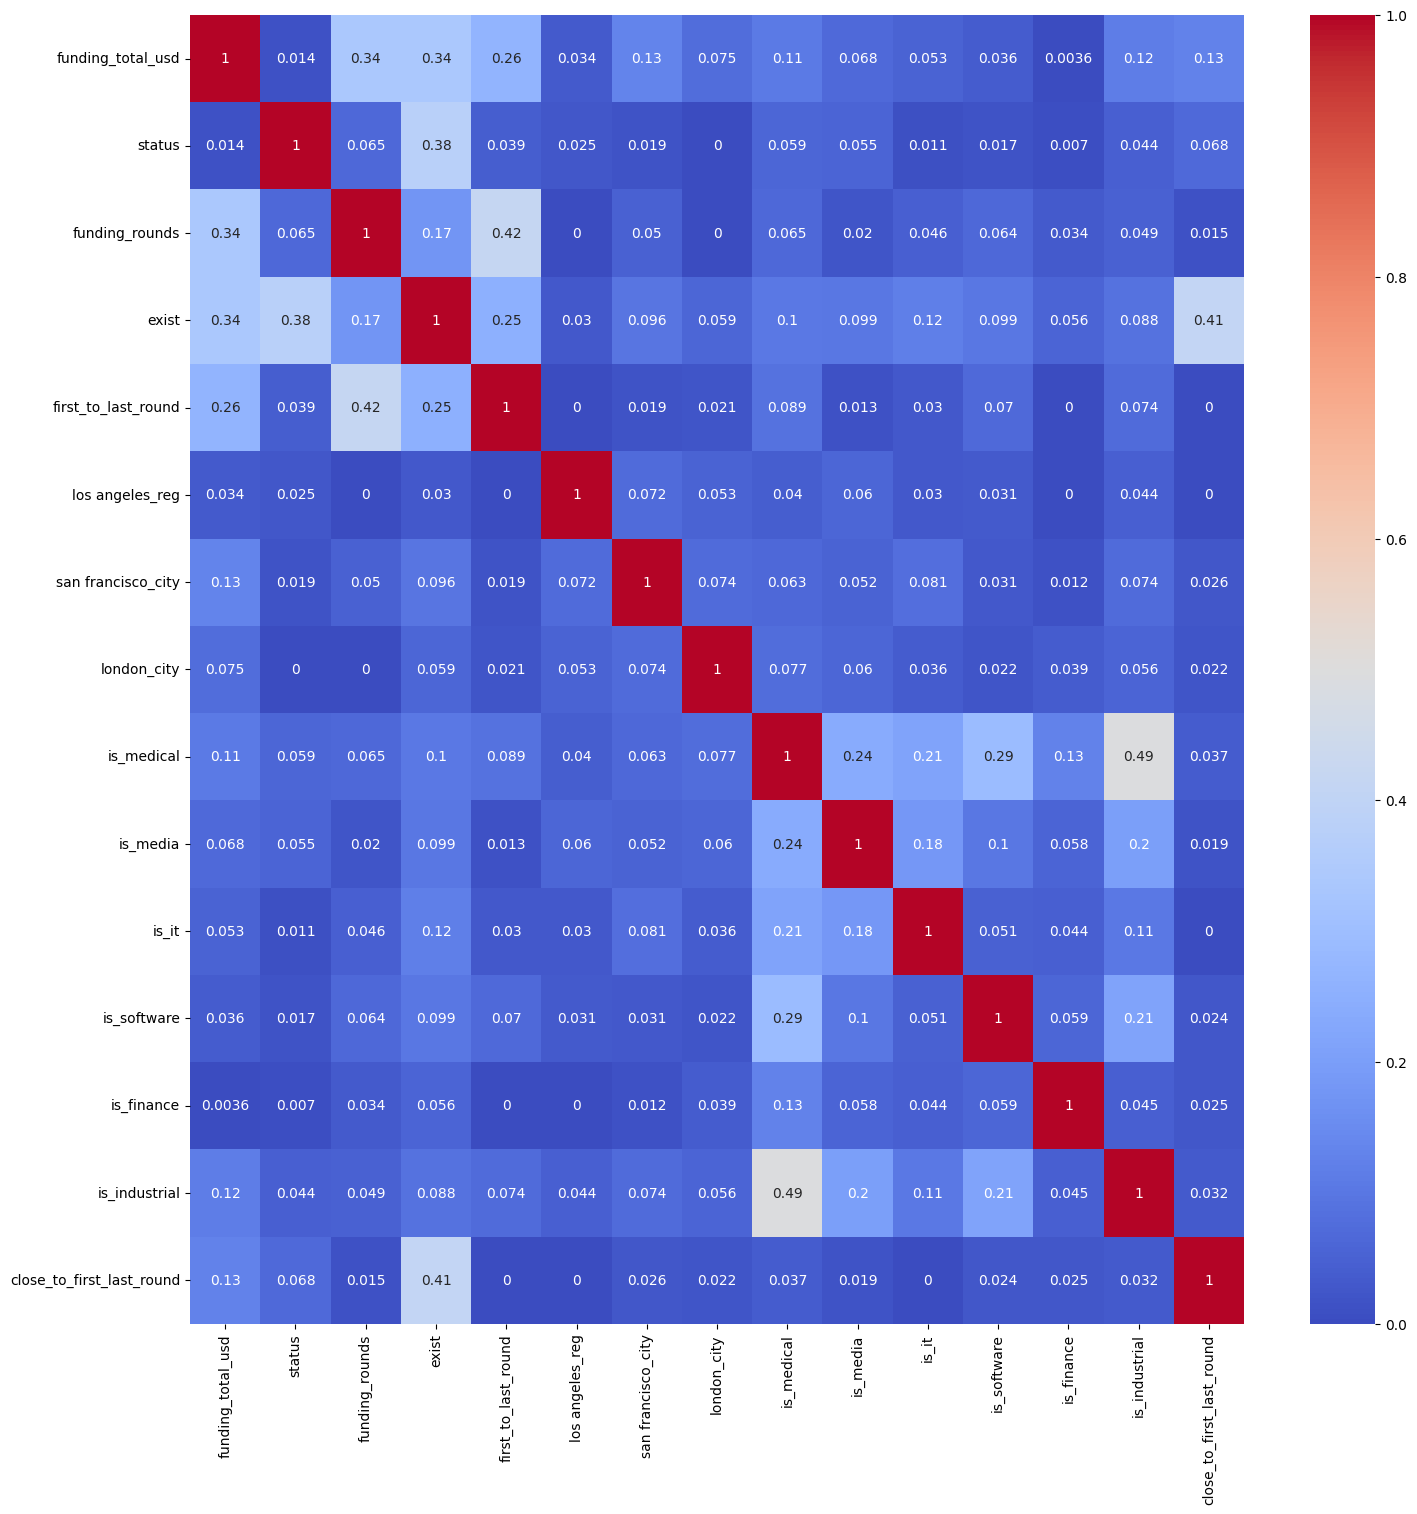

In [103]:
fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', ax=ax);

**Итого:** получилось избавиться от мультиколлинеарности в признаках даты

In [104]:
data = data.dropna()
data = data.reset_index(drop=True)

In [105]:
data.isna().sum()

funding_total_usd            0
status                       0
funding_rounds               0
exist                        0
first_to_last_round          0
los angeles_reg              0
san francisco_city           0
london_city                  0
is_medical                   0
is_media                     0
is_it                        0
is_software                  0
is_finance                   0
is_industrial                0
close_to_first_last_round    0
dtype: int64

**Вывод:** удалены лишние признаки

## Обучим модель

### Определим метрики и поделим данные

Оценивать модель будем по метрике f1_score, поскольку важно присваивать класс без ошибок (precision) и не пропускать объекты класса (recall), то есть учитывать две метрики сразу.

In [106]:
f1 = make_scorer(f1_score, pos_label=0) # минорный класс в Label Encoder будет закодирован нулём

Поделим данные на тренировочную и тестовую выборки.

In [107]:
#Тренировочные данные
X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop('status', axis=1),
    data['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=data['status']# стратифицируем по таргету
)

#Тестовые данные
X_test = data_test[X_train.columns]

### Построим пайплайн по подготовке данных.

In [108]:
num_cols = [
    'funding_total_usd',
    'funding_rounds',
    'exist',
    'first_to_last_round',
    'close_to_first_last_round'
]

cat_cols = [
    'los angeles_reg',
    'san francisco_city',
    'london_city',
    'is_medical',
    'is_media',
    'is_it',
    'is_software',
    'is_finance',
    'is_industrial'
]

all_cols = num_cols + cat_cols

Пайплайн для работы с категориальными данными будет только заполнять пропуски самым популярным значением. Кодирование мы уже выполнили вручную.

In [109]:
cat_pipe = Pipeline([('imputer_сat', SimpleImputer(strategy='most_frequent'))])

Пайплайн для масштабирования признаков и заполнения пропусков медианой:

In [110]:
num_pipe = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer_num', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols)
    ]
)

Соберём общий пайплайн подготовки данных.

In [111]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='passthrough'
)

**Итого:** построен пайплайн по подготовке данных.

### Закодируем таргет

In [112]:
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

y_train_labeled = pd.DataFrame(y_train_enc)
y_valid_labeled = pd.DataFrame(y_valid_enc)

In [113]:
train_target = y_train.sample(5, random_state=5)
train_label_target = y_train_labeled.sample(5, random_state=5)

valid_target = y_valid.sample(5, random_state=5)
valid_label_target = y_valid_labeled.sample(5, random_state=5)

display(pd.concat([train_target, train_label_target], axis=1))
print()
display(pd.concat([valid_target, valid_label_target], axis=1))

,status,0
21409,operating,NaN
17397,closed,NaN
33548,operating,NaN
11091,operating,NaN
7407,operating,NaN
26457,NaN,1.00
10678,NaN,0.00
21707,NaN,1.00
1848,NaN,1.00
18088,NaN,1.00


,status,0
32540,operating,NaN
19416,operating,NaN
30178,operating,NaN
10123,operating,NaN
18146,closed,NaN
1389,NaN,1.00
7479,NaN,1.00
5774,NaN,1.00
4266,NaN,1.00
5350,NaN,0.00


**Итого:** таргет закодирован, класс closed закодирован 0, а operated 1.

### Поработаем с логистической регрессией

#### Посторим пайплайн и сетку гиперпараметров

Построим полный пайплайн. В качестве base line модели выберем логистическую регрессию. 

In [114]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

Создадим сетку для перебора гиперпараметров.

In [115]:
param_grid_logistic_regression = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ['lbfgs', 'saga'],
        'models__penalty': ['l1', 'l2'],
        'models__C': [0.2, 0.4, 0.6, 0.8, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }

]

Найдём лучшую модель.

In [116]:
grid_log_reg = GridSearchCV(
    pipe_final, 
    param_grid_logistic_regression, 
    cv = 3,
    scoring=f1,
    n_jobs=-1
)

In [117]:
grid_log_reg.fit(X_train, y_train_labeled)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         ColumnTransformer(transformers=[('num',
                                                                                                          Pipeline(steps=[('imputer_num',
                                                                                                                           SimpleImputer(strategy='median')),
                                                                                                                          ('scaler',
                                                                                                                           StandardScaler())]),
                                                                                                          ['funding_total_usd',
                                                                                                           'funding_rounds',
                                                                                                           'exist',
                                                                                                           'first_to_last_round',
                                                                                                           'close_to_first_last_roun...
                                                                          'is_finance',
                                                                          'is_industrial'])])),
                                       ('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(C=1, random_state=42)],
                          'models__C': [0.2, 0.4, 0.6, 0.8, 1],
                          'models__penalty': ['l1', 'l2'],
                          'models__solver': ['lbfgs', 'saga'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]}],
             scoring=make_scorer(f1_score, pos_label=0))

Запись "45 fits failed out of a total of 180" не должна пугать - здесь всё закономерно. Решатель lbfgs не умеет работать с l1 регуляризацией. Всего 5 значений силы регуляризации (0.2, 0.4, 0.6, 0.8, 1), 3 способа масштабирования данных (StandardScaler(), MinMaxScaler(), RobustScaler()) и 3 раза обучаем модель на каждой итерации при кросс-валидации. Итого: 5 * 3 * 3 = 45 - вот эти 45 fits failed.

In [118]:
print('Лучшая модель и её параметры:\n\n', grid_log_reg.best_estimator_)
print ('Результат лучшей модели на кросс-валидации:', grid_log_reg.best_score_)
print('Лучшие гиперпараметры:', grid_log_reg.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'exist',
                                                   'first_to_last_round',
                                                   'close_to_first_last_round']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_сat',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['los angeles_reg',
                                                   'san francisco_city',
                                                   'london_city', 'is_medical',
                       

**Итого:** Лучшую метрику показала логистическая регрессия при силе регуляризации, равной 1, решателе lbfgs и масштабировании RobustScaler. В принципе, base line модель справилась с задачей хорошо. Метрика на кросс-валидации составила 0.9720.

#### Посмотрим на ошибки логистической регрессии

In [119]:
X_valid_preprocessed_for_log_reg = grid_log_reg.best_estimator_.named_steps['preprocessor']\
                                               .transform(X_valid)
X_valid_preprocessed_for_log_reg = pd.DataFrame(X_valid_preprocessed_for_log_reg, columns=all_cols)

In [120]:
X_valid_preprocessed_for_log_reg.head(10)

,funding_total_usd,funding_rounds,exist,first_to_last_round,close_to_first_last_round,los angeles_reg,san francisco_city,london_city,is_medical,is_media,is_it,is_software,is_finance,is_industrial
0,0.64,2.00,0.88,6.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,-0.13,0.00,0.08,0.00,0.70,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,4.77,1.00,-0.17,1.43,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.22,1.00,-0.30,0.80,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-0.35,0.00,0.03,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,0.05,0.00,-0.97,0.00,-0.54,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.32,0.00,-0.07,0.00,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,-0.08,0.00,-0.58,0.00,-0.40,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
8,-0.24,0.00,-0.46,0.00,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
9,1.10,0.00,1.91,0.00,8.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [121]:
model_log_reg = LogisticRegression(C=1, penalty='l2', solver='lbfgs', random_state=RANDOM_STATE)

x_Train_for_log_reg = grid_log_reg.best_estimator_.named_steps['preprocessor']\
                                  .transform(X_train[all_cols])

model_log_reg.fit(x_Train_for_log_reg, y_train_labeled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=42)

In [122]:
y_valid_pred_for_log_reg = model_log_reg.predict(X_valid_preprocessed_for_log_reg)

X has feature names, but LogisticRegression was fitted without feature names


Посмотрим на метрику F1.

In [123]:
f1_score(y_valid_labeled, y_valid_pred_for_log_reg, pos_label=0)

0.9809663250366032

**Итого:** на валидационных данных модель показала F1 метрику, равную 0.98.

Изучим матрицу ошибок.

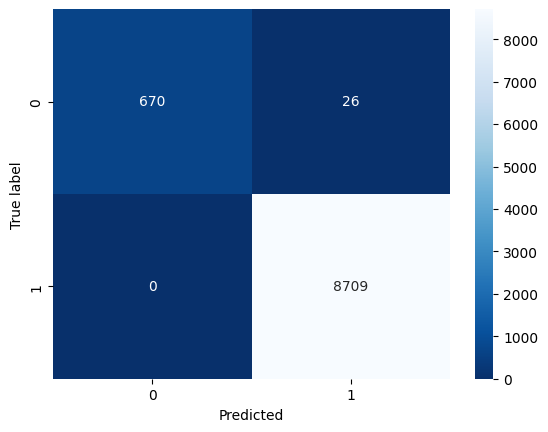

In [124]:
cm = confusion_matrix(y_valid_labeled, y_valid_pred_for_log_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

**Итого:** модель предсказала 26 закрытых компании как действующих.

#### Посмотрим на веса признаков логистической регрессии

In [125]:
feature_names = X_train.columns
coefficients = model_log_reg.coef_[0]

for feature, coef in zip(all_cols, coefficients):
    print(f"Признак: {feature}, Вес: {coef}")

Признак: funding_total_usd, Вес: -0.04285660112271262
Признак: funding_rounds, Вес: 0.3618786344975096
Признак: exist, Вес: 0.3619762206377238
Признак: first_to_last_round, Вес: -1.895822795963552
Признак: close_to_first_last_round, Вес: 33.09735161740799
Признак: los angeles_reg, Вес: -0.21430840056038997
Признак: san francisco_city, Вес: -0.058321918482265984
Признак: london_city, Вес: 0.36742972798636536
Признак: is_medical, Вес: 0.16816811289868053
Признак: is_media, Вес: -0.43489972336221444
Признак: is_it, Вес: 0.0967617730753371
Признак: is_software, Вес: -0.15437431168756227
Признак: is_finance, Вес: 0.12192495337451968
Признак: is_industrial, Вес: 0.07731230519151801


**Итого:** самым большим весом обладает созданный нами признак close_to_first_last_round, а самый маленький вес наблюдается у признака funding_rounds.

#### Настроим модель под бизнес-задачу
Кажется, что не лучший вариант для компании-инвестора вкладывать деньги в стартапы, которые закроются. Модель выше как раз допускает такую ошибку - закрытые компании считает действующими. На мой взгляд, выгоднее ошибиться и не вложить деньги в компанию, которая будет работать, чем вложить деньги в закроющуюся компанию.  
**Переведём бизнес-задачу на язык машинного обучения**: нам важно как можно реже допускать ошибку первого рода, т.е результат типа False Positive.

Для того, чтобы свести к минимому ошибку типа FP в логистической регресси, увеличим порог классификации.

In [126]:
# получим вероятность попадания в класс для валидационных данных
y_valid_proba = model_log_reg.predict_proba(X_valid_preprocessed_for_log_reg)[:,1]

# объединим данные
valid = pd.DataFrame(zip(y_valid_enc, y_valid_proba),columns = ['y_true', 'y_proba'])\
        .sort_values(by='y_proba',ascending=False) 

X has feature names, but LogisticRegression was fitted without feature names


In [127]:
valid.head()

,y_true,y_proba
4702,1,1.00
6248,1,1.00
6263,1,1.00
6260,1,1.00
6256,1,1.00


Создадим и переберём 20 пороговых значений. Найдем значение порога, при котором ошибка типа FP будет минимальной. Начнём сразу перебирать с значения 0.5, поскольку это стандратный порог классификации логистической регрессии, а нам нужно его увеличить

In [128]:
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 20,endpoint=False)]

for i in thresholds:
    valid['y_pred_'+str(i)] = valid['y_proba'].apply(lambda x: 1 if x >= i else 0)

In [129]:
valid.head()

,y_true,y_proba,y_pred_0.5,y_pred_0.52,y_pred_0.55,y_pred_0.57,y_pred_0.6,y_pred_0.62,y_pred_0.65,y_pred_0.68,...,y_pred_0.75,y_pred_0.78,y_pred_0.8,y_pred_0.82,y_pred_0.85,y_pred_0.88,y_pred_0.9,y_pred_0.92,y_pred_0.95,y_pred_0.98
4702,1,1.00,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6248,1,1.00,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6263,1,1.00,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6260,1,1.00,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6256,1,1.00,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Найдем столбец, в котором ошибка типа FP минимальна.

In [130]:
for i in thresholds:
    false_positive = valid[(valid['y_pred_'+str(i)] == 1) & (valid['y_true'] == 0)].shape[0]
    print(f'При значимости {i}, число ошибок FP равно {false_positive}')

При значимости 0.5, число ошибок FP равно 26
При значимости 0.52, число ошибок FP равно 20
При значимости 0.55, число ошибок FP равно 11
При значимости 0.57, число ошибок FP равно 9
При значимости 0.6, число ошибок FP равно 5
При значимости 0.62, число ошибок FP равно 4
При значимости 0.65, число ошибок FP равно 4
При значимости 0.68, число ошибок FP равно 3
При значимости 0.7, число ошибок FP равно 2
При значимости 0.72, число ошибок FP равно 1
При значимости 0.75, число ошибок FP равно 1
При значимости 0.78, число ошибок FP равно 1
При значимости 0.8, число ошибок FP равно 0
При значимости 0.82, число ошибок FP равно 0
При значимости 0.85, число ошибок FP равно 0
При значимости 0.88, число ошибок FP равно 0
При значимости 0.9, число ошибок FP равно 0
При значимости 0.92, число ошибок FP равно 0
При значимости 0.95, число ошибок FP равно 0
При значимости 0.98, число ошибок FP равно 0


Самое оптимальное значение порога 0.85, больше брать не имеет смысла. Построим новую матрицу ошибок, с учётом нового порога.

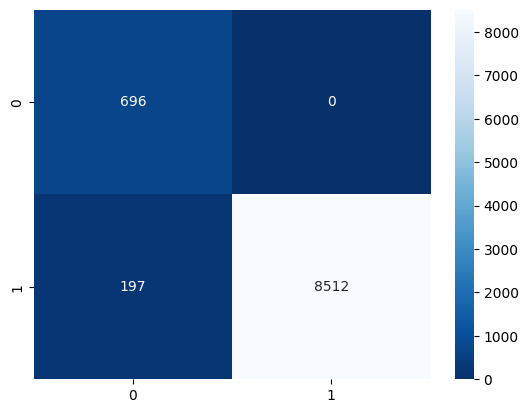

In [131]:
cm = confusion_matrix(valid['y_true'], valid['y_pred_0.8'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

**Итого**: ошибка типа FP сведена к нулю. Конечно, для соревнования я не буду использовать этот порог, поскольку задача соревнования - набрать метрику, но если бы это была бизнес-задача, то точно бы пришлось оставить этот порог

### Поработаем с деревом решений

#### Используем тот же пайплайн pipe_final, только другую сетку гиперпараметров

In [132]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

In [133]:
param_grid_decition_tree = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [134]:
grid_tree = GridSearchCV(
    pipe_final, 
    param_grid_decition_tree, 
    cv = 3,
    scoring=f1,
    n_jobs=-1
)

In [135]:
grid_tree.fit(X_train, y_train_labeled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         ColumnTransformer(transformers=[('num',
                                                                                                          Pipeline(steps=[('imputer_num',
                                                                                                                           SimpleImputer(strategy='median')),
                                                                                                                          ('scaler',
                                                                                                                           StandardScaler())]),
                                                                                                          ['funding_total_usd',
                                                                                                           'funding_rounds',
                                                                                                           'exist',
                                                                                                           'first_to_last_round',
                                                                                                           'close_to_first_last_roun...
                                                                          'is_industrial'])])),
                                       ('models', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(max_depth=9,
                                                            max_features=7,
                                                            random_state=42)],
                          'models__max_depth': range(2, 10),
                          'models__max_features': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(f1_score, pos_label=0))

In [136]:
print('Лучшая модель и её параметры:\n\n', grid_tree.best_estimator_)
print ('Результат лучшей модели на кросс-валидации:', grid_tree.best_score_)
print('Лучшие гиперпараметры:', grid_tree.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'exist',
                                                   'first_to_last_round',
                                                   'close_to_first_last_round']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_сat',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['los angeles_reg',
                                                   'san francisco_city',
                                                   'london_city', 'is_medical',
                     

**Итого:** нашли лучшие гиперпараметры модели. Лучшая модель выдала F1 = 0.988. Гиперпараметр depth (глубина дерева) достиг максимального из перебираемых. Не будем увеличивать диапазон, поскольку это может привести к переобучению.

#### Посмотрим на ошибки дерева решений

In [137]:
model_tree = DecisionTreeClassifier(max_depth=9, max_features=7, random_state=RANDOM_STATE)

In [138]:
X_valid_preprocessed_for_tree = grid_tree.best_estimator_.named_steps['preprocessor']\
                                   .transform(X_valid)
X_valid_preprocessed_for_tree = pd.DataFrame(X_valid_preprocessed_for_tree, columns=all_cols)

In [139]:
X_valid_preprocessed_for_tree.head()

,funding_total_usd,funding_rounds,exist,first_to_last_round,close_to_first_last_round,los angeles_reg,san francisco_city,london_city,is_medical,is_media,is_it,is_software,is_finance,is_industrial
0,0.08,1.28,0.58,3.16,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,-0.49,-0.55,-0.21,-0.49,0.08,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,3.13,0.37,-0.45,0.38,-0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.23,0.37,-0.58,-0.00,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-0.65,-0.55,-0.25,-0.49,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [140]:
x_Train_for_tree = grid_tree.best_estimator_.named_steps['preprocessor'].transform(X_train[all_cols])

In [141]:
model_tree.fit(x_Train_for_tree, y_train_labeled)

DecisionTreeClassifier(max_depth=9, max_features=7, random_state=42)

In [142]:
y_valid_pred_for_tree = model_tree.predict(X_valid_preprocessed_for_tree)

X has feature names, but DecisionTreeClassifier was fitted without feature names


Посмотрим на F1 метрику.

In [143]:
f1_score(y_valid_labeled, y_valid_pred_for_tree, pos_label=0)

0.9701383831026948

**Итого:** метрика F1 на дереве решений равна 0.97, впечатляющий результат.

Изучим матрицу ошибок

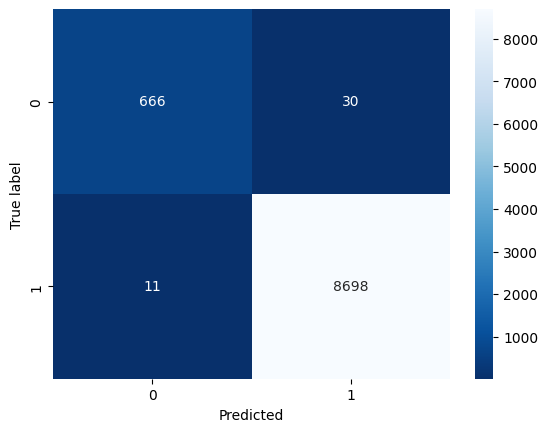

In [144]:
cm = confusion_matrix(y_valid_labeled, y_valid_pred_for_tree)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

**Итого:** на модели "Дерево решений" получилась метрика получше да и ошибок она допустила меньше. Для сравнения - логистическая регрессия допустила 24 ошибки, а дерево решений 11. Заметим, что дерево допускает ошибки первого и второго рода, в отличии от логистической регрессии.

### Оценим важность признаков для каждой модели

#### Оценим важность признаков логистической регрессии

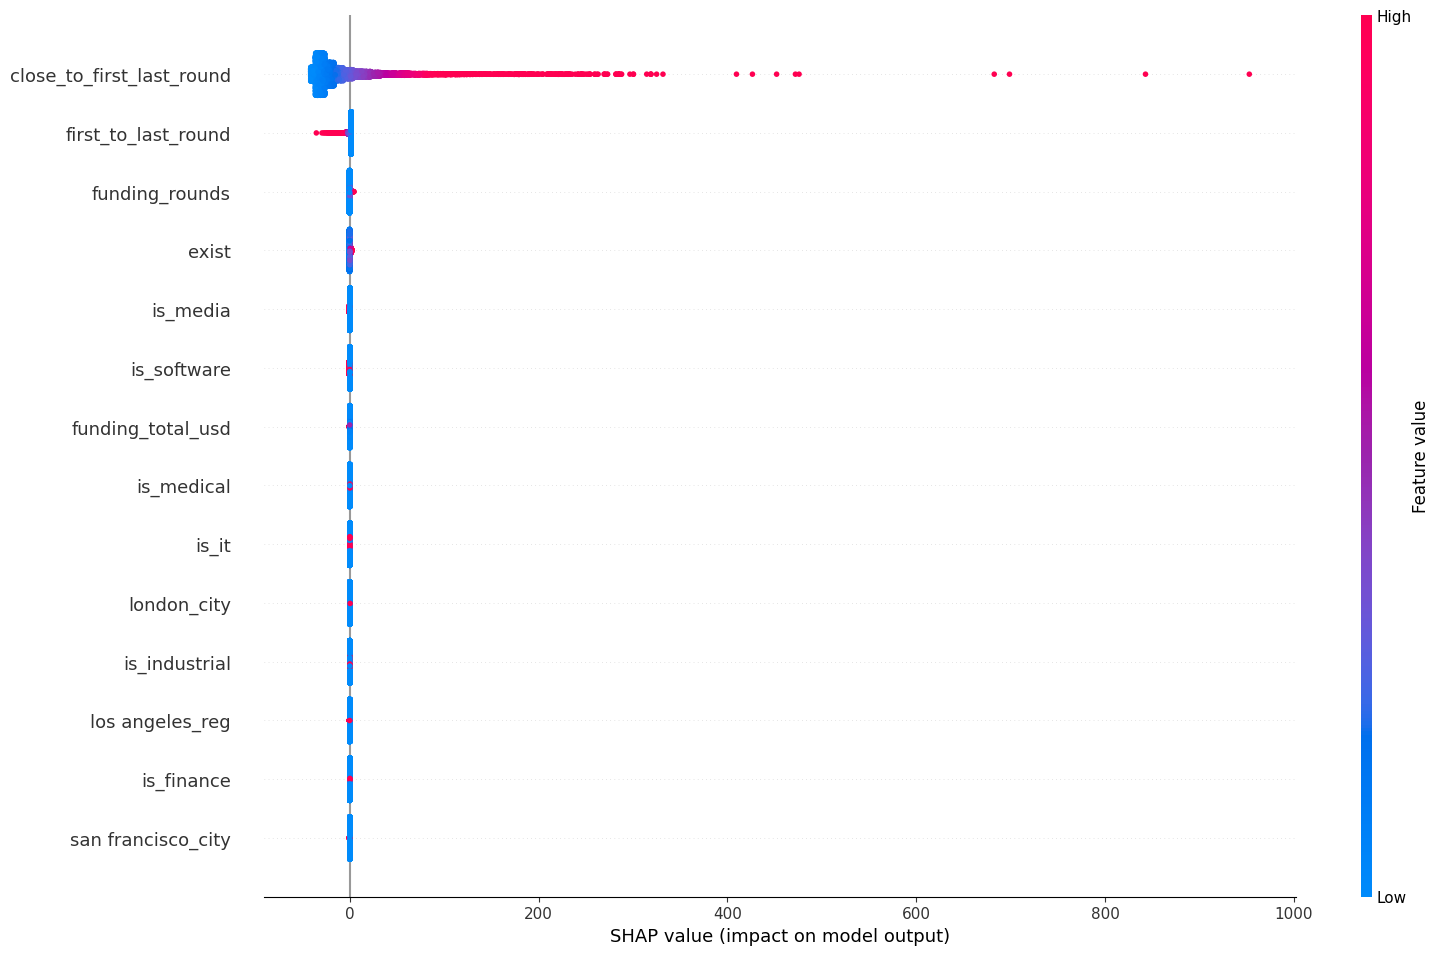

In [145]:
explainer = shap.LinearExplainer(model_log_reg, x_Train_for_log_reg)
shap_values = explainer.shap_values(X_valid_preprocessed_for_log_reg[all_cols])
shap.summary_plot(shap_values, X_valid_preprocessed_for_log_reg, show=False)

plt.gcf().set_size_inches(20, 10)
plt.show()

**Итого:** как и было заявлено ранее, самый весомый признак в логистической регресси - close_to_first_last_round. Чем больше значение этого признака, тем более вероятно присвоение класса 1. Совсем не сильно, но всё-таки оказывается влияние признак first_to_last_round - чем он больше, тем более вероятно, что стартап закроется.

#### Оценим важность признаков дерева решений  
Поскольку признаки в модели "Дерево решений" не обладают весами, то выведем лишь важность этих признаков по встроенному методу (критерий важности Джинни).

In [146]:
feat_importances = pd.DataFrame(zip(X_valid_preprocessed_for_tree[all_cols], \
                                     model_tree.feature_importances_),\
                                     columns = ['feature', 'important_gini'])\
        .sort_values(by='important_gini',ascending=False)

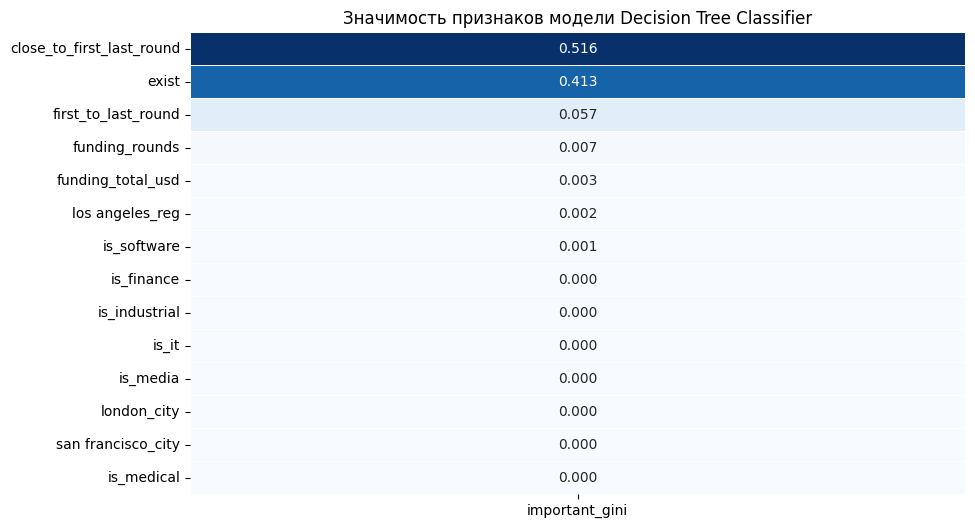

In [147]:
feat_importances = feat_importances.sort_values(by='important_gini', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(feat_importances[['important_gini']], \
                 annot=True, fmt=".3f", cmap='Blues', \
                 cbar=False, linewidths=0.5)
ax.set_yticklabels(feat_importances['feature'], rotation=0)
plt.title("Значимость признаков модели Decision Tree Classifier")
plt.show()

**Итого:** модель "Дерево решений" дала более интересный результат, поскольку важны уже несколько признаков. Такая модель более доверительна для нас.

Визуально покажем структуру дерева решений.

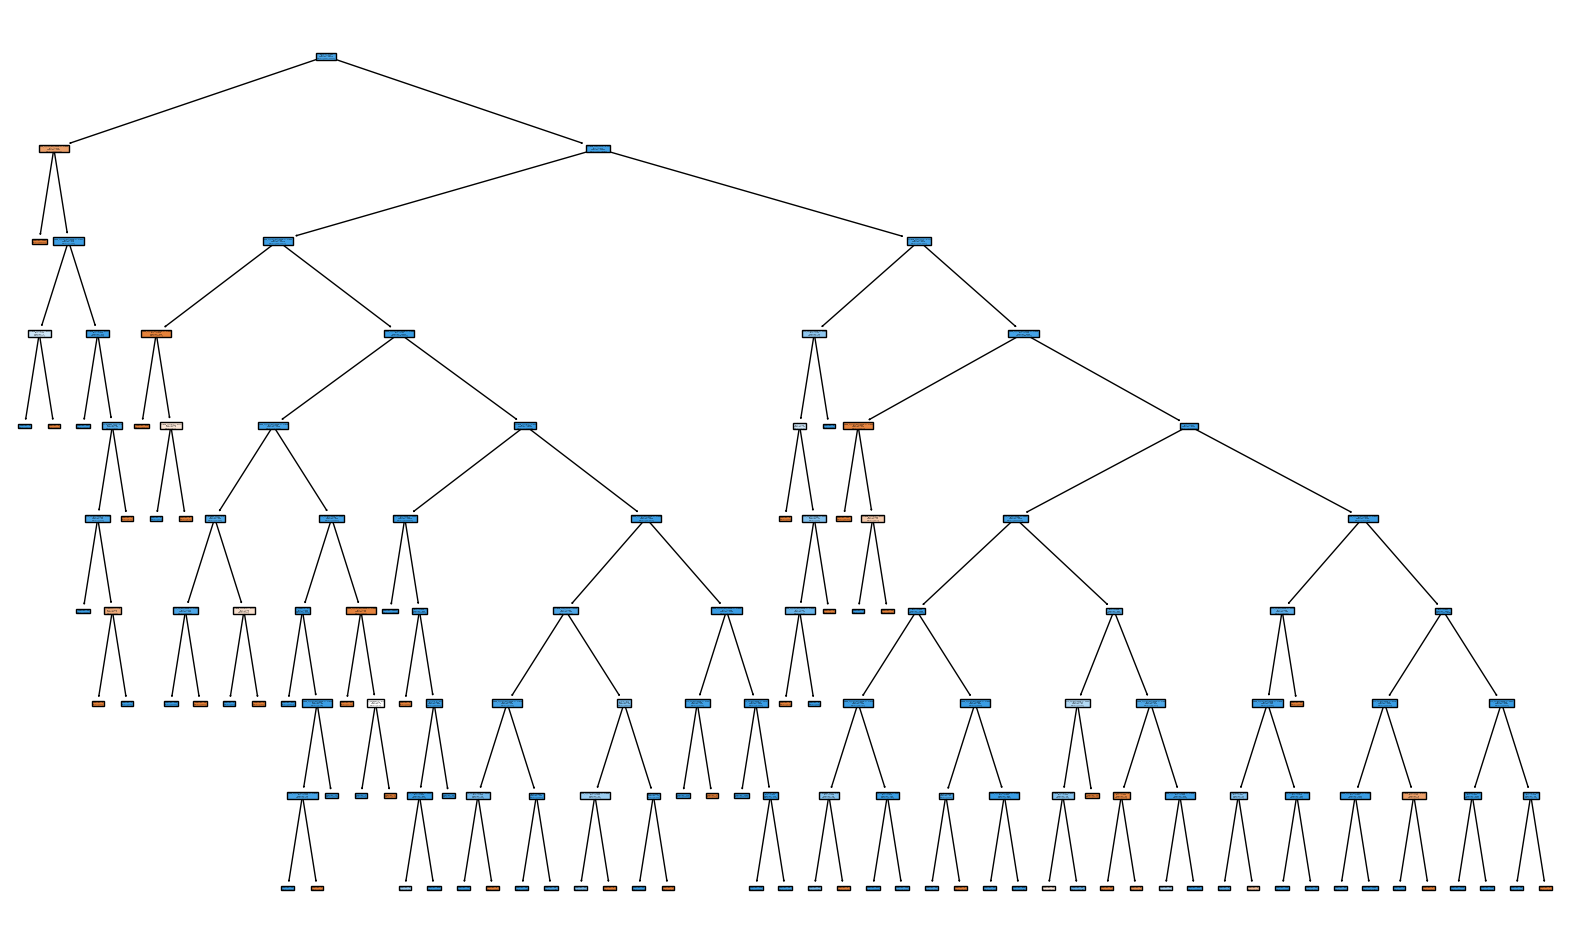

In [148]:
plt.figure(figsize=(20, 12))
plot_tree(model_tree, feature_names=all_cols, filled=True)
plt.show()

## Получим предскзания

### Получим предсказания логистической регрессии

In [149]:
data_log_reg = data_test
data_tree = data_test

Подготовим тестовые данные.

In [150]:
test_log_reg = grid_log_reg.best_estimator_.named_steps['preprocessor'].transform(data_log_reg)
test_log_reg_frame = pd.DataFrame(data = test_log_reg, columns = all_cols)

In [151]:
test_log_reg_frame.head()

,funding_total_usd,funding_rounds,exist,first_to_last_round,close_to_first_last_round,los angeles_reg,san francisco_city,london_city,is_medical,is_media,is_it,is_software,is_finance,is_industrial
0,0.18,0.00,0.45,0.00,1.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,1.51,0.00,0.08,0.00,1.09,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,-0.33,1.00,-0.61,0.37,-0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,6.94,3.00,1.05,5.72,2.45,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.54,0.00,1.76,0.00,2.86,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [152]:
test_log_reg_frame.isna().sum()

funding_total_usd            0
funding_rounds               0
exist                        0
first_to_last_round          0
close_to_first_last_round    0
los angeles_reg              0
san francisco_city           0
london_city                  0
is_medical                   0
is_media                     0
is_it                        0
is_software                  0
is_finance                   0
is_industrial                0
dtype: int64

In [153]:
test_log_reg = test_log_reg_frame.values

Сделаем предсказания и заполним ими столбец тестовых данных.

In [154]:
data_log_reg['status'] = model_log_reg.predict(test_log_reg)

In [155]:
data_log_reg.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,is_services,is_commerce,is_it,is_software,is_finance,is_industrial,is_entertainment,open_to_first_last_round,close_to_first_last_round,status
0,Crystalsol,clean technology,2819200.00,nic,17,NaN,NaN,1,2008-06-01,2009-07-01,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,156025,9647236,1
1,JBI Fish & Wings,hospitality,9084161.00,usa,tn,tn - other,humboldt,1,2010-07-25,2010-07-28,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,9,7365796,1
2,COINPLUS,finance,428257.00,lux,3,esch-sur-alzette,esch-sur-alzette,2,2014-06-16,2014-05-15,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-3008,1593727,1
3,Imagine Communications,software|video|video streaming,34700000.00,usa,ca,san diego,san diego,4,2005-01-01,2005-01-01,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0,13356124,1
4,DNA13,software,4530000.00,can,on,ottawa,ottawa,1,2001-01-01,2007-05-08,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,5373124,15139881,1


In [156]:
data_log_reg = data_log_reg[sample_submit.columns]

In [157]:
data_log_reg['status'] = label_encoder.inverse_transform(data_log_reg['status'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [158]:
data_log_reg.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


Экспортируем файл с предсказаниями.

In [159]:
data_log_reg.to_csv('supmition_log_reg_final_.csv', index=False)

### Получим предсказания дерева решений

In [160]:
test_tree = data_tree[X_train.columns]
test_tree = grid_tree.best_estimator_.named_steps['preprocessor'].transform(test_tree)
test_tree_frame = pd.DataFrame(data = test_tree, columns = X_train.columns)
test_tree_frame.head()

,funding_total_usd,funding_rounds,exist,first_to_last_round,los angeles_reg,san francisco_city,london_city,is_medical,is_media,is_it,is_software,is_finance,is_industrial,close_to_first_last_round
0,-0.26,-0.55,0.16,-0.49,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,0.72,-0.55,-0.21,-0.49,0.33,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,-0.63,0.37,-0.88,-0.26,-0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,4.73,2.20,0.76,2.99,1.17,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.01,-0.55,1.45,-0.49,1.42,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [161]:
test_tree = test_tree_frame.values

In [162]:
data_tree['status'] = model_tree.predict(test_tree)

In [163]:
data_tree = data_tree[sample_submit.columns]
data_tree['status'] = label_encoder.inverse_transform(data_tree['status'])
data_tree.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


Экспортируем файл с предсказаниями.

In [164]:
data_tree.to_csv('supmition_tree_final_.csv', index=False)

## Общий вывод по работе
В ходе работы над проектом был проведён обширный анализ данных о стартапах, функционировавших с 1980 по 2018 годы, с целью предсказания их дальнейшей судьбы.  
Задача заключалась в разработке модели машинного обучения для предсказания закрытия стартапов, а также в проведении разведочного анализа данных для выявления факторов, влияющих на успешность стартапов.  
Все эти задачи выполнены в ходе проекта, поэтому рассмотрим выводы по каждому пункту:  
1) **Загрузка и ознакомление с данными**: загружены небходимые библиотеки для анализа данных и машинного обучения, созданы функции для исследовательского анализа данных. Загружены файлы с данными, изучена общая информация о датасетах.  

2) **Предобработка данных**: значения с датами приведены в нужный формат, данные изучены на явные и неявыне дубликаты - они обнаружены не были. Выполнена работа с пропусками: пропуски в датах были заполнены датой выгрузки файлов, пропуски в числовых столбцах были заполнены медианой значений аналогичных объектов (с таким же географическим положением). Удалены малоинформативыне объекты.  В общей сложности не первичном обработке удалено 13% данных.    

3) **EDA**: изучены числовые столбцы - определено, что медианная сумма финансирования равна 2150000 долларов. Максимальная сумма финансирования равна 30079503000 долларов, а минимальная - 1 доллар. Среднее количество инвестиционных раундов при этом равно 1. Выяснилось, что в данных есть дисбаланс классов - в процентом соотношении, закрытых компаний 7.7%, а действующих 92.3%. Определены виды распределений числовых признаков - ни один из признаков не был нормально распределён, что оказалось важным на этапе корреляционного анализа данных. Определены пути формирования новых признаков, о них ниже.  

**Определены факторы, влияющие на успешность стартапа** - выполнены статистические тесты и на их основе определено, что cреднее значение общей суммы финансирования и количество инвестиционных раундов больше в успешных компаниях. Разница сумм инвестиций примерно равна 500000 долларов в пользу действующих компаний, разница в количестве инвестиционных незначительна. Ещё немаловажным результатом анализа является то, что географическое положение практически не оказывает влияние на успех.  

4) **Созданы новые признаки**: извлечены новые признаки из основных дат жизнедеятельности компаний. Также созданы признаки на основе описания компаний - был выделены 9 основных категории компании и каждой категории были присвоены ключевые слова. Эти ключевые слова были найдены в описании компании и на основе этого присваивалась категория. 

5) **Проведён анализ на мультиколлинеарность и отбор признаков** - найдена и удалена мультиколлинеарность признаков путём частичного удаления признаков и понижением размерности.

6) **Обучены модели логистической регрессии и дерево решений**: в качестве метрики была выбрана F1-score, поскольку важно присваивать класс без ошибок (precision) и не пропускать объекты класса (recall), то есть учитывать две метрики сразу. Построены полные пайплайны, включающие подготовку данных и обучение модели. Лучшие гиперпараметры модели были найдены с помощью поиска по сетке (GridSearchCV). Метрика F1-score на кросс-валидации у логистической регрессии равна 0.9743, а у дерева решений - 9875. Рассмотрим каждую модель подробнее:  
* **Логистическая регрессия**: результат на валидационных данных составил 0.98. При изучении ошибок модели, выяснилось, что модель допустила 26 ошибок типа FP (Ошибка первого рода - кода модель закрывшиеся компании предсказала действующими) и 0 ошибок типа FN (Ошибок второго рода - когда модель действующие компании предсказала закрытыми). Для бизнеса важно иметь другую картину - лучшие ошибаться и не инвестировать в стартапы, чем инвестировать в неуспешные стартапы. Поэтому было решено свести ошибку первого рода к нулю - был увеличен порог классификации модель с 0.5 до 0.8 - при этом ошибку второго рода получаем 197 раз, то есть 197 раз успешные компании называем неуспешными.  
* **Дерево решений**: метрика на валидационных данных равна 0.97. Модель допустила ошибку первого рода 12 раз, ошибку второго рода 5 раз. В целом, это на 9 ошибок меньше, чем в логистической регрессии.  

7) **Оценена важность признаков каждой модели**: коэффициенты SHAP говорят, что модель логистической регресси берёт в расчет только два признака: close_to_last_round - чем он больше, тем вероятнее присвоение класса 1 (стартап действует) и first_to_last_round - чем он больше, тем вероятнее присвоение класса 0 (стартап закроется). На остальные признаки логистическая регрессия обращает мало внимания. У дерева решений история поинтереснее - самых значащий признак по-прежнему close_to_last_round, немного меньше влияет признак exist (сколько компания существует). Также изучена структура дерева решений.  

В общем и целом, не тестовом датасета лучше всего себя показала модель "Дерево решений" - её обобщающая способность оказалась лучше. На этом проект выполнен.